##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Load text

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/text"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates two ways to load and preprocess text.

- First, you will use Keras utilities and preprocessing layers. These include `tf.keras.utils.text_dataset_from_directory` to turn data into a `tf.data.Dataset` and `tf.keras.layers.TextVectorization` for data standardization, tokenization, and vectorization. If you are new to TensorFlow, you should start with these.
- Then, you will use lower-level utilities like `tf.data.TextLineDataset` to load text files, `tf.lookup` for custom in-model lookup tables, and [TensorFlow Text](https://www.tensorflow.org/text) APIs, such as `text.UnicodeScriptTokenizer` and `text.case_fold_utf8`, to preprocess the data for finer-grain control.

In [2]:
!pip install "tensorflow-text==2.13.*"

  Using cached google_auth-2.33.0-py2.py3-none-any.whl.metadata (4.7 kB)


  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.


  Using cached pyasn1_modules-0.4.0-py3-none-any.whl.metadata (3.4 kB)


  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)


  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)


  Using cached pyasn1-0.6.0-py2.py3-none-any.whl.metadata (8.3 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)


Using cached google_auth-2.33.0-py2.py3-none-any.whl (200 kB)
Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
Using cached pyasn1_modules-0.4.0-py3-none-any.whl (181 kB)
Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl (24 kB)
Using cached rsa-4.9-py3-none-any.whl (34 kB)
Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Using cached pyasn1-0.6.0-py2.py3-none-any.whl (85 kB)


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:


      Successfully uninstalled typing_extensions-4.12.2


  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0


    Uninstalling tf_keras-2.17.0:
      Successfully uninstalled tf_keras-2.17.0


  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4


    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  Attempting uninstall: keras
    Found existing installation: keras 3.5.0


    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      Successfully uninstalled gast-0.6.0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1


    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0


    Uninstalling tensorflow-2.17.0:


      Successfully uninstalled tensorflow-2.17.0


In [3]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

## Example 1: Predict the tag for a Stack Overflow question

As a first example, you will download a dataset of programming questions from Stack Overflow. Each question (_"How do I sort a dictionary by value?"_) is labeled with exactly one tag (`Python`, `CSharp`, `JavaScript`, or `Java`). Your task is to develop a model that predicts the tag for a question. This is an example of multi-class classification—an important and widely applicable kind of machine learning problem.

To implement this task, you'll start with the simplest tools:

* `keras.utils.text_datasaet_from_directory`: for loading text-file examples.
* `keras.layers.TextVectorization`: for converting strings to token indices.


### Download and explore the dataset

Begin by downloading the Stack Overflow dataset using `tf.keras.utils.get_file`, and exploring the directory structure:

In [4]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

   8192/6053168 [..............................] - ETA: 0s

4202496/6053168 [===================>..........] - ETA: 0s

6053168/6053168 [==============================] - 0s 0us/step


In [5]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/train'),
 PosixPath('/tmp/.keras/test')]

In [6]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/javascript')]

The `train/csharp`, `train/java`, `train/python` and `train/javascript` directories contain many text files, each of which is a Stack Overflow question.

Print an example file and inspect the data:

In [7]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



### Load the dataset

Next, you will load the data off-disk and prepare it into a format suitable for training. To do so, you will use the `tf.keras.utils.text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. If you're new to `tf.data`, it's a powerful collection of tools for building input pipelines. (Learn more in the [tf.data: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.)

The `tf.keras.utils.text_dataset_from_directory` API expects a directory structure as follows:

```
train/
...csharp/
......1.txt
......2.txt
...java/
......1.txt
......2.txt
...javascript/
......1.txt
......2.txt
...python/
......1.txt
......2.txt
```

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [training](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The Stack Overflow dataset has already been divided into training and test sets, but it lacks a validation set.

Create a validation set using an 80:20 split of the training data by using `tf.keras.utils.text_dataset_from_directory` with `validation_split` set to `0.2` (i.e. 20%):

In [8]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.


Using 6400 files for training.


2024-08-16 07:38:27.487373: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


As the previous cell output suggests, there are 8,000 examples in the training folder, of which you will use 80% (or 6,400) for training. You will learn in a moment that you can train a model by passing a `tf.data.Dataset` directly to `Model.fit`.

First, iterate over the dataset and print out a few examples, to get a feel for the data.

Note: To increase the difficulty of the classification problem, the dataset author replaced occurrences of the words *Python*, *CSharp*, *JavaScript*, or *Java* in the programming question with the word *blank*.

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

The labels are `0`, `1`, `2` or `3`. To check which of these correspond to which string label, you can inspect the `class_names` property on the dataset:


In [10]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and a test set using `tf.keras.utils.text_dataset_from_directory`. You will use the remaining 1,600 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments of `tf.keras.utils.text_dataset_from_directory`, make sure to either specify a random seed or pass `shuffle=False`, so that the validation and training splits have no overlap.

In [11]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.


Using 1600 files for validation.


In [12]:
test_dir = dataset_dir/'test'

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Configure the datasets for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

- `Dataset.cache` keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [13]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

This first example will keep things simple by integrating the text processing into the model. But you may be able to increase performance by moving the text processing into the dataset pipeline, this is demonstrated in [Example 2](#example2)

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the `tf.keras.layers.TextVectorization` layer.

- _Standardization_ refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
- _Tokenization_ refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).
- _Vectorization_ refers to converting tokens into numbers so they can be fed into a neural network.

All of these tasks can be accomplished with this layer. (You can learn more about each of these in the `tf.keras.layers.TextVectorization` API docs.)

Note that:

- The default standardization converts text to lowercase and removes punctuation (`standardize='lower_and_strip_punctuation'`).
- The default tokenizer splits on whitespace (`split='whitespace'`).
- The default vectorization mode is `'int'` (`output_mode='int'`). This outputs integer indices (one per token). This mode can be used to build models that take word order into account. You can also use other modes—like `'binary'`—to build [bag-of-words](https://developers.google.com/machine-learning/glossary#bag-of-words) models.

You will build two models to learn more about standardization, tokenization, and vectorization with `TextVectorization`:

- First, you will use the `'binary'` vectorization mode to build a bag-of-words model.
- Then, you will use the `'int'` mode with a 1D ConvNet.

In [14]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

For the `'int'` mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length (`MAX_SEQUENCE_LENGTH`), which will cause the layer to pad or truncate sequences to exactly `output_sequence_length` values:

In [15]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

Next, call `TextVectorization.adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling `TextVectorization.adapt`, as using the test set would leak information.

In [16]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Print the result of using these layers to preprocess data:

In [17]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


The binary vectorization layer returns a multi-hot vector, with a 1 in the location for each token that was in the input string.

'binary' vectorized question: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,

(0.0, 1000.0)

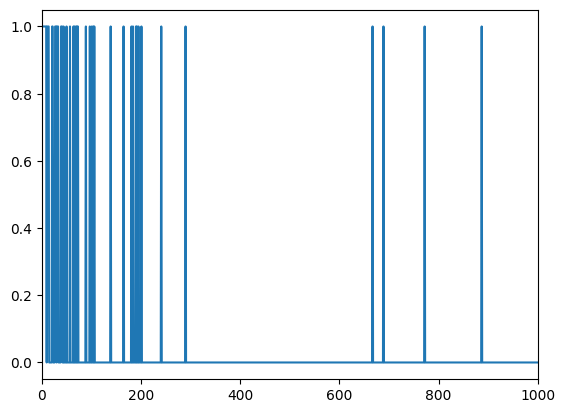

In [18]:
print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [19]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
  196   12   74   13   72   33    2   98  105   14    3   70 9611    3
   34  888  202  773  107    8   41  242   40   58  291   90    3  196
  191   10    2  182    6  668    6   13   30 1187   12  773   22   42
    1   28    5  140   29 5213   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   67    6   32   65  185  166  102   14
    2   65    6    1  193    9 2784   45 2410    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

As shown above, `TextVectorization`'s `'binary'` mode returns an array denoting which tokens exist at least once in the input, while the `'int'` mode replaces each token by an integer, thus preserving their order.

You can lookup the token (string) that each integer corresponds to by calling `TextVectorization.get_vocabulary` on the layer:

In [20]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source


Vocabulary size: 10000


### Train the model

It's time to create your neural network.

For the `'binary'` vectorized data, define a simple bag-of-words linear model, then configure and train it:

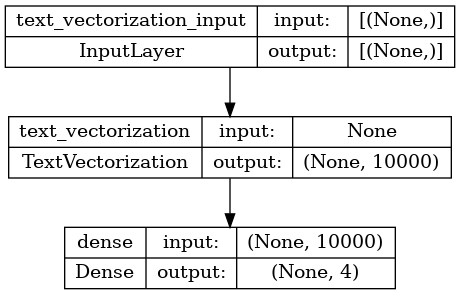

In [21]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [22]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

print()

Epoch 1/10


  1/200 [..............................] - ETA: 1:25 - loss: 1.4060 - accuracy: 0.2500

 13/200 [>.............................] - ETA: 0s - loss: 1.3622 - accuracy: 0.2909  

 27/200 [===>..........................] - ETA: 0s - loss: 1.3559 - accuracy: 0.3171

 40/200 [=====>........................] - ETA: 0s - loss: 1.3298 - accuracy: 0.3828

 55/200 [=======>......................] - ETA: 0s - loss: 1.3071 - accuracy: 0.4460

 69/200 [=========>....................] - ETA: 0s - loss: 1.2857 - accuracy: 0.4828

 84/200 [===========>..................] - ETA: 0s - loss: 1.2655 - accuracy: 0.5167

 98/200 [=============>................] - ETA: 0s - loss: 1.2444 - accuracy: 0.5446

113/200 [===============>..............] - ETA: 0s - loss: 1.2244 - accuracy: 0.5644

128/200 [==================>...........] - ETA: 0s - loss: 1.2051 - accuracy: 0.5854

144/200 [====================>.........] - ETA: 0s - loss: 1.1875 - accuracy: 0.5977

159/200 [======================>.......] - ETA: 0s - loss: 1.1674 - accuracy: 0.6124

173/200 [========================>.....] - ETA: 0s - loss: 1.1505 - accuracy: 0.6194

188/200 [===========================>..] - ETA: 0s - loss: 1.1342 - accuracy: 0.6283

200/200 [==============================] - 1s 5ms/step - loss: 1.1224 - accuracy: 0.6353 - val_loss: 0.9172 - val_accuracy: 0.7806


Epoch 2/10


  1/200 [..............................] - ETA: 0s - loss: 0.9027 - accuracy: 0.7812

 16/200 [=>............................] - ETA: 0s - loss: 0.8512 - accuracy: 0.8203

 32/200 [===>..........................] - ETA: 0s - loss: 0.8569 - accuracy: 0.8164

 47/200 [======>.......................] - ETA: 0s - loss: 0.8515 - accuracy: 0.8191

 62/200 [========>.....................] - ETA: 0s - loss: 0.8402 - accuracy: 0.8185

 77/200 [==========>...................] - ETA: 0s - loss: 0.8325 - accuracy: 0.8210

 92/200 [============>.................] - ETA: 0s - loss: 0.8279 - accuracy: 0.8193

107/200 [===============>..............] - ETA: 0s - loss: 0.8226 - accuracy: 0.8178

122/200 [=================>............] - ETA: 0s - loss: 0.8164 - accuracy: 0.8184

137/200 [===================>..........] - ETA: 0s - loss: 0.8106 - accuracy: 0.8180

152/200 [=====================>........] - ETA: 0s - loss: 0.8030 - accuracy: 0.8185

166/200 [=======================>......] - ETA: 0s - loss: 0.7947 - accuracy: 0.8180

180/200 [==========================>...] - ETA: 0s - loss: 0.7874 - accuracy: 0.8175

194/200 [============================>.] - ETA: 0s - loss: 0.7822 - accuracy: 0.8175

200/200 [==============================] - 1s 4ms/step - loss: 0.7810 - accuracy: 0.8166 - val_loss: 0.7519 - val_accuracy: 0.8037


Epoch 3/10


  1/200 [..............................] - ETA: 0s - loss: 0.7448 - accuracy: 0.8438

 16/200 [=>............................] - ETA: 0s - loss: 0.6700 - accuracy: 0.8496

 32/200 [===>..........................] - ETA: 0s - loss: 0.6734 - accuracy: 0.8486

 47/200 [======>.......................] - ETA: 0s - loss: 0.6712 - accuracy: 0.8537

 62/200 [========>.....................] - ETA: 0s - loss: 0.6617 - accuracy: 0.8574

 78/200 [==========>...................] - ETA: 0s - loss: 0.6568 - accuracy: 0.8594

 93/200 [============>.................] - ETA: 0s - loss: 0.6563 - accuracy: 0.8572

108/200 [===============>..............] - ETA: 0s - loss: 0.6514 - accuracy: 0.8547

123/200 [=================>............] - ETA: 0s - loss: 0.6497 - accuracy: 0.8542

139/200 [===================>..........] - ETA: 0s - loss: 0.6478 - accuracy: 0.8541

153/200 [=====================>........] - ETA: 0s - loss: 0.6427 - accuracy: 0.8560

167/200 [========================>.....] - ETA: 0s - loss: 0.6363 - accuracy: 0.8567

181/200 [==========================>...] - ETA: 0s - loss: 0.6318 - accuracy: 0.8574

195/200 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.8569

200/200 [==============================] - 1s 4ms/step - loss: 0.6289 - accuracy: 0.8564 - val_loss: 0.6655 - val_accuracy: 0.8181


Epoch 4/10


  1/200 [..............................] - ETA: 0s - loss: 0.6377 - accuracy: 0.8438

 16/200 [=>............................] - ETA: 0s - loss: 0.5662 - accuracy: 0.8828

 32/200 [===>..........................] - ETA: 0s - loss: 0.5678 - accuracy: 0.8828

 47/200 [======>.......................] - ETA: 0s - loss: 0.5662 - accuracy: 0.8843

 62/200 [========>.....................] - ETA: 0s - loss: 0.5571 - accuracy: 0.8876

 78/200 [==========>...................] - ETA: 0s - loss: 0.5537 - accuracy: 0.8870

 93/200 [============>.................] - ETA: 0s - loss: 0.5546 - accuracy: 0.8864

108/200 [===============>..............] - ETA: 0s - loss: 0.5505 - accuracy: 0.8845

123/200 [=================>............] - ETA: 0s - loss: 0.5501 - accuracy: 0.8847

138/200 [===================>..........] - ETA: 0s - loss: 0.5497 - accuracy: 0.8854

153/200 [=====================>........] - ETA: 0s - loss: 0.5454 - accuracy: 0.8868

168/200 [========================>.....] - ETA: 0s - loss: 0.5403 - accuracy: 0.8873

183/200 [==========================>...] - ETA: 0s - loss: 0.5368 - accuracy: 0.8878

198/200 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8886

200/200 [==============================] - 1s 4ms/step - loss: 0.5351 - accuracy: 0.8878 - val_loss: 0.6117 - val_accuracy: 0.8288


Epoch 5/10


  1/200 [..............................] - ETA: 1s - loss: 0.5579 - accuracy: 0.8750

 16/200 [=>............................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8984

 31/200 [===>..........................] - ETA: 0s - loss: 0.4960 - accuracy: 0.9012

 46/200 [=====>........................] - ETA: 0s - loss: 0.4958 - accuracy: 0.9035

 61/200 [========>.....................] - ETA: 0s - loss: 0.4858 - accuracy: 0.9057

 76/200 [==========>...................] - ETA: 0s - loss: 0.4818 - accuracy: 0.9042

 91/200 [============>.................] - ETA: 0s - loss: 0.4845 - accuracy: 0.9038

105/200 [==============>...............] - ETA: 0s - loss: 0.4833 - accuracy: 0.9006

120/200 [=================>............] - ETA: 0s - loss: 0.4830 - accuracy: 0.8987

135/200 [===================>..........] - ETA: 0s - loss: 0.4805 - accuracy: 0.9005

150/200 [=====================>........] - ETA: 0s - loss: 0.4773 - accuracy: 0.9021

164/200 [=======================>......] - ETA: 0s - loss: 0.4733 - accuracy: 0.9028

178/200 [=========================>....] - ETA: 0s - loss: 0.4713 - accuracy: 0.9026

192/200 [===========================>..] - ETA: 0s - loss: 0.4687 - accuracy: 0.9036

200/200 [==============================] - 1s 4ms/step - loss: 0.4689 - accuracy: 0.9031 - val_loss: 0.5748 - val_accuracy: 0.8350


Epoch 6/10


  1/200 [..............................] - ETA: 0s - loss: 0.4950 - accuracy: 0.9688

 16/200 [=>............................] - ETA: 0s - loss: 0.4435 - accuracy: 0.9121

 31/200 [===>..........................] - ETA: 0s - loss: 0.4426 - accuracy: 0.9163

 46/200 [=====>........................] - ETA: 0s - loss: 0.4418 - accuracy: 0.9178

 61/200 [========>.....................] - ETA: 0s - loss: 0.4323 - accuracy: 0.9196

 77/200 [==========>...................] - ETA: 0s - loss: 0.4297 - accuracy: 0.9180

 92/200 [============>.................] - ETA: 0s - loss: 0.4314 - accuracy: 0.9171

107/200 [===============>..............] - ETA: 0s - loss: 0.4298 - accuracy: 0.9150

122/200 [=================>............] - ETA: 0s - loss: 0.4293 - accuracy: 0.9137

137/200 [===================>..........] - ETA: 0s - loss: 0.4280 - accuracy: 0.9147

152/200 [=====================>........] - ETA: 0s - loss: 0.4254 - accuracy: 0.9155

167/200 [========================>.....] - ETA: 0s - loss: 0.4214 - accuracy: 0.9160

181/200 [==========================>...] - ETA: 0s - loss: 0.4192 - accuracy: 0.9163

195/200 [============================>.] - ETA: 0s - loss: 0.4191 - accuracy: 0.9175

200/200 [==============================] - 1s 4ms/step - loss: 0.4184 - accuracy: 0.9177 - val_loss: 0.5480 - val_accuracy: 0.8356


Epoch 7/10


  1/200 [..............................] - ETA: 0s - loss: 0.4438 - accuracy: 0.9688

 16/200 [=>............................] - ETA: 0s - loss: 0.4022 - accuracy: 0.9199

 31/200 [===>..........................] - ETA: 0s - loss: 0.4005 - accuracy: 0.9254

 46/200 [=====>........................] - ETA: 0s - loss: 0.3991 - accuracy: 0.9266

 60/200 [========>.....................] - ETA: 0s - loss: 0.3896 - accuracy: 0.9292

 75/200 [==========>...................] - ETA: 0s - loss: 0.3858 - accuracy: 0.9287

 90/200 [============>.................] - ETA: 0s - loss: 0.3888 - accuracy: 0.9267

105/200 [==============>...............] - ETA: 0s - loss: 0.3884 - accuracy: 0.9244

120/200 [=================>............] - ETA: 0s - loss: 0.3889 - accuracy: 0.9229

135/200 [===================>..........] - ETA: 0s - loss: 0.3870 - accuracy: 0.9245

150/200 [=====================>........] - ETA: 0s - loss: 0.3842 - accuracy: 0.9254

165/200 [=======================>......] - ETA: 0s - loss: 0.3812 - accuracy: 0.9252

179/200 [=========================>....] - ETA: 0s - loss: 0.3790 - accuracy: 0.9262

194/200 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.9275

200/200 [==============================] - 1s 4ms/step - loss: 0.3781 - accuracy: 0.9275 - val_loss: 0.5278 - val_accuracy: 0.8388


Epoch 8/10


  1/200 [..............................] - ETA: 0s - loss: 0.4009 - accuracy: 0.9688

 16/200 [=>............................] - ETA: 0s - loss: 0.3685 - accuracy: 0.9297

 31/200 [===>..........................] - ETA: 0s - loss: 0.3660 - accuracy: 0.9335

 46/200 [=====>........................] - ETA: 0s - loss: 0.3641 - accuracy: 0.9341

 60/200 [========>.....................] - ETA: 0s - loss: 0.3549 - accuracy: 0.9370

 76/200 [==========>...................] - ETA: 0s - loss: 0.3518 - accuracy: 0.9354

 91/200 [============>.................] - ETA: 0s - loss: 0.3554 - accuracy: 0.9337

105/200 [==============>...............] - ETA: 0s - loss: 0.3539 - accuracy: 0.9336

120/200 [=================>............] - ETA: 0s - loss: 0.3545 - accuracy: 0.9318

135/200 [===================>..........] - ETA: 0s - loss: 0.3529 - accuracy: 0.9329

150/200 [=====================>........] - ETA: 0s - loss: 0.3501 - accuracy: 0.9344

165/200 [=======================>......] - ETA: 0s - loss: 0.3474 - accuracy: 0.9341

179/200 [=========================>....] - ETA: 0s - loss: 0.3455 - accuracy: 0.9352

194/200 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.9359

200/200 [==============================] - 1s 4ms/step - loss: 0.3447 - accuracy: 0.9358 - val_loss: 0.5122 - val_accuracy: 0.8406


Epoch 9/10


  1/200 [..............................] - ETA: 0s - loss: 0.3644 - accuracy: 0.9688

 16/200 [=>............................] - ETA: 0s - loss: 0.3401 - accuracy: 0.9316

 32/200 [===>..........................] - ETA: 0s - loss: 0.3361 - accuracy: 0.9385

 47/200 [======>.......................] - ETA: 0s - loss: 0.3331 - accuracy: 0.9402

 62/200 [========>.....................] - ETA: 0s - loss: 0.3257 - accuracy: 0.9415

 78/200 [==========>...................] - ETA: 0s - loss: 0.3240 - accuracy: 0.9403

 94/200 [=============>................] - ETA: 0s - loss: 0.3251 - accuracy: 0.9395

109/200 [===============>..............] - ETA: 0s - loss: 0.3224 - accuracy: 0.9395

124/200 [=================>............] - ETA: 0s - loss: 0.3237 - accuracy: 0.9385

139/200 [===================>..........] - ETA: 0s - loss: 0.3237 - accuracy: 0.9384

154/200 [======================>.......] - ETA: 0s - loss: 0.3220 - accuracy: 0.9391

169/200 [========================>.....] - ETA: 0s - loss: 0.3187 - accuracy: 0.9406

183/200 [==========================>...] - ETA: 0s - loss: 0.3169 - accuracy: 0.9418

198/200 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.9421

200/200 [==============================] - 1s 4ms/step - loss: 0.3165 - accuracy: 0.9417 - val_loss: 0.5000 - val_accuracy: 0.8419


Epoch 10/10


  1/200 [..............................] - ETA: 0s - loss: 0.3329 - accuracy: 0.9688

 16/200 [=>............................] - ETA: 0s - loss: 0.3156 - accuracy: 0.9414

 31/200 [===>..........................] - ETA: 0s - loss: 0.3120 - accuracy: 0.9456

 46/200 [=====>........................] - ETA: 0s - loss: 0.3091 - accuracy: 0.9477

 61/200 [========>.....................] - ETA: 0s - loss: 0.3009 - accuracy: 0.9498

 76/200 [==========>...................] - ETA: 0s - loss: 0.2977 - accuracy: 0.9515

 91/200 [============>.................] - ETA: 0s - loss: 0.3013 - accuracy: 0.9485

106/200 [==============>...............] - ETA: 0s - loss: 0.2998 - accuracy: 0.9493

121/200 [=================>............] - ETA: 0s - loss: 0.3001 - accuracy: 0.9478

136/200 [===================>..........] - ETA: 0s - loss: 0.2989 - accuracy: 0.9476

151/200 [=====================>........] - ETA: 0s - loss: 0.2967 - accuracy: 0.9489

166/200 [=======================>......] - ETA: 0s - loss: 0.2945 - accuracy: 0.9494

180/200 [==========================>...] - ETA: 0s - loss: 0.2925 - accuracy: 0.9505

195/200 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.9502

200/200 [==============================] - 1s 4ms/step - loss: 0.2921 - accuracy: 0.9500 - val_loss: 0.4903 - val_accuracy: 0.8431


Next, you will use the `'int'` vectorized layer to build a 1D ConvNet:

In [23]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

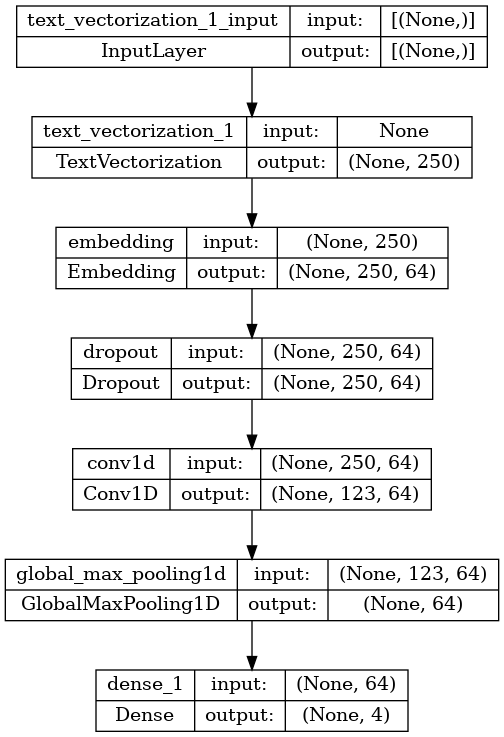

In [24]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

tf.keras.utils.plot_model(int_model, show_shapes=True)

In [25]:

int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10


  1/200 [..............................] - ETA: 2:08 - loss: 1.4045 - accuracy: 0.1875

  5/200 [..............................] - ETA: 2s - loss: 1.4005 - accuracy: 0.1750  

 10/200 [>.............................] - ETA: 2s - loss: 1.3919 - accuracy: 0.2250

 16/200 [=>............................] - ETA: 2s - loss: 1.3845 - accuracy: 0.2793

 22/200 [==>...........................] - ETA: 1s - loss: 1.3899 - accuracy: 0.2614

 27/200 [===>..........................] - ETA: 1s - loss: 1.3885 - accuracy: 0.2639

 33/200 [===>..........................] - ETA: 1s - loss: 1.3880 - accuracy: 0.2718

 39/200 [====>.........................] - ETA: 1s - loss: 1.3875 - accuracy: 0.2716

 45/200 [=====>........................] - ETA: 1s - loss: 1.3868 - accuracy: 0.2694

 51/200 [======>.......................] - ETA: 1s - loss: 1.3861 - accuracy: 0.2739

 57/200 [=======>......................] - ETA: 1s - loss: 1.3850 - accuracy: 0.2834

 63/200 [========>.....................] - ETA: 1s - loss: 1.3836 - accuracy: 0.2857

 69/200 [=========>....................] - ETA: 1s - loss: 1.3836 - accuracy: 0.2840

 75/200 [==========>...................] - ETA: 1s - loss: 1.3819 - accuracy: 0.2933

 81/200 [===========>..................] - ETA: 1s - loss: 1.3811 - accuracy: 0.2986

 87/200 [============>.................] - ETA: 1s - loss: 1.3797 - accuracy: 0.3046

 93/200 [============>.................] - ETA: 1s - loss: 1.3777 - accuracy: 0.3135

 99/200 [=============>................] - ETA: 0s - loss: 1.3763 - accuracy: 0.3157

105/200 [==============>...............] - ETA: 0s - loss: 1.3746 - accuracy: 0.3179

111/200 [===============>..............] - ETA: 0s - loss: 1.3710 - accuracy: 0.3229

117/200 [================>.............] - ETA: 0s - loss: 1.3683 - accuracy: 0.3264

123/200 [=================>............] - ETA: 0s - loss: 1.3640 - accuracy: 0.3356

129/200 [==================>...........] - ETA: 0s - loss: 1.3587 - accuracy: 0.3435

134/200 [===================>..........] - ETA: 0s - loss: 1.3550 - accuracy: 0.3489

140/200 [====================>.........] - ETA: 0s - loss: 1.3505 - accuracy: 0.3560

146/200 [====================>.........] - ETA: 0s - loss: 1.3441 - accuracy: 0.3645

152/200 [=====================>........] - ETA: 0s - loss: 1.3364 - accuracy: 0.3711

158/200 [======================>.......] - ETA: 0s - loss: 1.3302 - accuracy: 0.3770

164/200 [=======================>......] - ETA: 0s - loss: 1.3209 - accuracy: 0.3822

170/200 [========================>.....] - ETA: 0s - loss: 1.3127 - accuracy: 0.3882

176/200 [=========================>....] - ETA: 0s - loss: 1.3050 - accuracy: 0.3938

182/200 [==========================>...] - ETA: 0s - loss: 1.2949 - accuracy: 0.4004

188/200 [===========================>..] - ETA: 0s - loss: 1.2873 - accuracy: 0.4041

194/200 [============================>.] - ETA: 0s - loss: 1.2764 - accuracy: 0.4106

200/200 [==============================] - ETA: 0s - loss: 1.2680 - accuracy: 0.4155

200/200 [==============================] - 3s 11ms/step - loss: 1.2680 - accuracy: 0.4155 - val_loss: 0.9306 - val_accuracy: 0.6119


Epoch 2/10


  1/200 [..............................] - ETA: 2s - loss: 1.0030 - accuracy: 0.5625

  7/200 [>.............................] - ETA: 1s - loss: 0.9912 - accuracy: 0.5625

 13/200 [>.............................] - ETA: 1s - loss: 0.9671 - accuracy: 0.5841

 19/200 [=>............................] - ETA: 1s - loss: 0.9539 - accuracy: 0.5905

 25/200 [==>...........................] - ETA: 1s - loss: 0.9303 - accuracy: 0.5975

 31/200 [===>..........................] - ETA: 1s - loss: 0.9321 - accuracy: 0.5978

 37/200 [====>.........................] - ETA: 1s - loss: 0.9140 - accuracy: 0.6064

 43/200 [=====>........................] - ETA: 1s - loss: 0.9024 - accuracy: 0.6090

 49/200 [======>.......................] - ETA: 1s - loss: 0.8936 - accuracy: 0.6110

 55/200 [=======>......................] - ETA: 1s - loss: 0.8870 - accuracy: 0.6148

 61/200 [========>.....................] - ETA: 1s - loss: 0.8847 - accuracy: 0.6189

 67/200 [=========>....................] - ETA: 1s - loss: 0.8832 - accuracy: 0.6203

 73/200 [=========>....................] - ETA: 1s - loss: 0.8723 - accuracy: 0.6259

 79/200 [==========>...................] - ETA: 1s - loss: 0.8654 - accuracy: 0.6317

 85/200 [===========>..................] - ETA: 1s - loss: 0.8663 - accuracy: 0.6301

 91/200 [============>.................] - ETA: 0s - loss: 0.8579 - accuracy: 0.6326

 96/200 [=============>................] - ETA: 0s - loss: 0.8536 - accuracy: 0.6344

102/200 [==============>...............] - ETA: 0s - loss: 0.8516 - accuracy: 0.6360

108/200 [===============>..............] - ETA: 0s - loss: 0.8405 - accuracy: 0.6432

114/200 [================>.............] - ETA: 0s - loss: 0.8387 - accuracy: 0.6450

120/200 [=================>............] - ETA: 0s - loss: 0.8353 - accuracy: 0.6458

126/200 [=================>............] - ETA: 0s - loss: 0.8302 - accuracy: 0.6486

132/200 [==================>...........] - ETA: 0s - loss: 0.8271 - accuracy: 0.6522

138/200 [===================>..........] - ETA: 0s - loss: 0.8269 - accuracy: 0.6517

144/200 [====================>.........] - ETA: 0s - loss: 0.8228 - accuracy: 0.6554

150/200 [=====================>........] - ETA: 0s - loss: 0.8148 - accuracy: 0.6592

156/200 [======================>.......] - ETA: 0s - loss: 0.8123 - accuracy: 0.6615

162/200 [=======================>......] - ETA: 0s - loss: 0.8062 - accuracy: 0.6640

168/200 [========================>.....] - ETA: 0s - loss: 0.7997 - accuracy: 0.6656

174/200 [=========================>....] - ETA: 0s - loss: 0.7954 - accuracy: 0.6661

180/200 [==========================>...] - ETA: 0s - loss: 0.7902 - accuracy: 0.6679

186/200 [==========================>...] - ETA: 0s - loss: 0.7879 - accuracy: 0.6700

192/200 [===========================>..] - ETA: 0s - loss: 0.7834 - accuracy: 0.6722

198/200 [============================>.] - ETA: 0s - loss: 0.7799 - accuracy: 0.6735

200/200 [==============================] - 2s 10ms/step - loss: 0.7792 - accuracy: 0.6737 - val_loss: 0.6409 - val_accuracy: 0.7419


Epoch 3/10


  1/200 [..............................] - ETA: 1s - loss: 0.6403 - accuracy: 0.7188

  7/200 [>.............................] - ETA: 1s - loss: 0.7084 - accuracy: 0.7188

 13/200 [>.............................] - ETA: 1s - loss: 0.6703 - accuracy: 0.7308

 19/200 [=>............................] - ETA: 1s - loss: 0.6543 - accuracy: 0.7451

 25/200 [==>...........................] - ETA: 1s - loss: 0.6303 - accuracy: 0.7538

 31/200 [===>..........................] - ETA: 1s - loss: 0.6325 - accuracy: 0.7550

 37/200 [====>.........................] - ETA: 1s - loss: 0.6165 - accuracy: 0.7584

 43/200 [=====>........................] - ETA: 1s - loss: 0.6143 - accuracy: 0.7616

 49/200 [======>.......................] - ETA: 1s - loss: 0.6145 - accuracy: 0.7557

 55/200 [=======>......................] - ETA: 1s - loss: 0.6115 - accuracy: 0.7580

 61/200 [========>.....................] - ETA: 1s - loss: 0.6136 - accuracy: 0.7567

 67/200 [=========>....................] - ETA: 1s - loss: 0.6138 - accuracy: 0.7565

 73/200 [=========>....................] - ETA: 1s - loss: 0.6050 - accuracy: 0.7590

 79/200 [==========>...................] - ETA: 1s - loss: 0.6023 - accuracy: 0.7623

 85/200 [===========>..................] - ETA: 1s - loss: 0.6041 - accuracy: 0.7614

 91/200 [============>.................] - ETA: 0s - loss: 0.6014 - accuracy: 0.7630

 97/200 [=============>................] - ETA: 0s - loss: 0.6000 - accuracy: 0.7632

103/200 [==============>...............] - ETA: 0s - loss: 0.6011 - accuracy: 0.7621

109/200 [===============>..............] - ETA: 0s - loss: 0.5952 - accuracy: 0.7663

115/200 [================>.............] - ETA: 0s - loss: 0.5938 - accuracy: 0.7682

121/200 [=================>............] - ETA: 0s - loss: 0.5921 - accuracy: 0.7699

127/200 [==================>...........] - ETA: 0s - loss: 0.5876 - accuracy: 0.7714

133/200 [==================>...........] - ETA: 0s - loss: 0.5851 - accuracy: 0.7735

139/200 [===================>..........] - ETA: 0s - loss: 0.5870 - accuracy: 0.7732

145/200 [====================>.........] - ETA: 0s - loss: 0.5867 - accuracy: 0.7737

150/200 [=====================>........] - ETA: 0s - loss: 0.5794 - accuracy: 0.7769

156/200 [======================>.......] - ETA: 0s - loss: 0.5783 - accuracy: 0.7780

162/200 [=======================>......] - ETA: 0s - loss: 0.5754 - accuracy: 0.7780

168/200 [========================>.....] - ETA: 0s - loss: 0.5737 - accuracy: 0.7781

174/200 [=========================>....] - ETA: 0s - loss: 0.5702 - accuracy: 0.7802

180/200 [==========================>...] - ETA: 0s - loss: 0.5659 - accuracy: 0.7819

186/200 [==========================>...] - ETA: 0s - loss: 0.5659 - accuracy: 0.7819

192/200 [===========================>..] - ETA: 0s - loss: 0.5639 - accuracy: 0.7837

198/200 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.7846

200/200 [==============================] - 2s 10ms/step - loss: 0.5617 - accuracy: 0.7848 - val_loss: 0.5409 - val_accuracy: 0.8025


Epoch 4/10


  1/200 [..............................] - ETA: 1s - loss: 0.4108 - accuracy: 0.9375

  7/200 [>.............................] - ETA: 1s - loss: 0.5307 - accuracy: 0.8259

 13/200 [>.............................] - ETA: 1s - loss: 0.4952 - accuracy: 0.8341

 19/200 [=>............................] - ETA: 1s - loss: 0.4839 - accuracy: 0.8289

 25/200 [==>...........................] - ETA: 1s - loss: 0.4703 - accuracy: 0.8413

 31/200 [===>..........................] - ETA: 1s - loss: 0.4712 - accuracy: 0.8417

 37/200 [====>.........................] - ETA: 1s - loss: 0.4564 - accuracy: 0.8480

 43/200 [=====>........................] - ETA: 1s - loss: 0.4561 - accuracy: 0.8459

 49/200 [======>.......................] - ETA: 1s - loss: 0.4549 - accuracy: 0.8438

 55/200 [=======>......................] - ETA: 1s - loss: 0.4501 - accuracy: 0.8449

 61/200 [========>.....................] - ETA: 1s - loss: 0.4508 - accuracy: 0.8458

 66/200 [========>.....................] - ETA: 1s - loss: 0.4482 - accuracy: 0.8485

 72/200 [=========>....................] - ETA: 1s - loss: 0.4450 - accuracy: 0.8485

 78/200 [==========>...................] - ETA: 1s - loss: 0.4401 - accuracy: 0.8514

 84/200 [===========>..................] - ETA: 1s - loss: 0.4389 - accuracy: 0.8523

 90/200 [============>.................] - ETA: 0s - loss: 0.4383 - accuracy: 0.8524

 96/200 [=============>................] - ETA: 0s - loss: 0.4404 - accuracy: 0.8499

102/200 [==============>...............] - ETA: 0s - loss: 0.4452 - accuracy: 0.8477

108/200 [===============>..............] - ETA: 0s - loss: 0.4391 - accuracy: 0.8501

114/200 [================>.............] - ETA: 0s - loss: 0.4400 - accuracy: 0.8514

120/200 [=================>............] - ETA: 0s - loss: 0.4393 - accuracy: 0.8523

125/200 [=================>............] - ETA: 0s - loss: 0.4346 - accuracy: 0.8540

131/200 [==================>...........] - ETA: 0s - loss: 0.4337 - accuracy: 0.8526

137/200 [===================>..........] - ETA: 0s - loss: 0.4340 - accuracy: 0.8515

143/200 [====================>.........] - ETA: 0s - loss: 0.4335 - accuracy: 0.8512

149/200 [=====================>........] - ETA: 0s - loss: 0.4288 - accuracy: 0.8538

155/200 [======================>.......] - ETA: 0s - loss: 0.4273 - accuracy: 0.8548

161/200 [=======================>......] - ETA: 0s - loss: 0.4235 - accuracy: 0.8564

167/200 [========================>.....] - ETA: 0s - loss: 0.4209 - accuracy: 0.8567

173/200 [========================>.....] - ETA: 0s - loss: 0.4213 - accuracy: 0.8566

179/200 [=========================>....] - ETA: 0s - loss: 0.4175 - accuracy: 0.8579

185/200 [==========================>...] - ETA: 0s - loss: 0.4168 - accuracy: 0.8579

191/200 [===========================>..] - ETA: 0s - loss: 0.4162 - accuracy: 0.8583

197/200 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8587

200/200 [==============================] - 2s 10ms/step - loss: 0.4142 - accuracy: 0.8589 - val_loss: 0.4931 - val_accuracy: 0.8125


Epoch 5/10


  1/200 [..............................] - ETA: 1s - loss: 0.3039 - accuracy: 0.9062

  7/200 [>.............................] - ETA: 1s - loss: 0.4040 - accuracy: 0.8527

 13/200 [>.............................] - ETA: 1s - loss: 0.3704 - accuracy: 0.8702

 19/200 [=>............................] - ETA: 1s - loss: 0.3646 - accuracy: 0.8766

 25/200 [==>...........................] - ETA: 1s - loss: 0.3510 - accuracy: 0.8850

 31/200 [===>..........................] - ETA: 1s - loss: 0.3476 - accuracy: 0.8881

 37/200 [====>.........................] - ETA: 1s - loss: 0.3342 - accuracy: 0.8961

 43/200 [=====>........................] - ETA: 1s - loss: 0.3331 - accuracy: 0.8961

 49/200 [======>.......................] - ETA: 1s - loss: 0.3328 - accuracy: 0.8954

 55/200 [=======>......................] - ETA: 1s - loss: 0.3279 - accuracy: 0.8983

 61/200 [========>.....................] - ETA: 1s - loss: 0.3275 - accuracy: 0.8975

 67/200 [=========>....................] - ETA: 1s - loss: 0.3262 - accuracy: 0.8983

 73/200 [=========>....................] - ETA: 1s - loss: 0.3182 - accuracy: 0.9007

 79/200 [==========>...................] - ETA: 1s - loss: 0.3178 - accuracy: 0.9007

 85/200 [===========>..................] - ETA: 1s - loss: 0.3186 - accuracy: 0.8993

 91/200 [============>.................] - ETA: 0s - loss: 0.3209 - accuracy: 0.8973

 97/200 [=============>................] - ETA: 0s - loss: 0.3209 - accuracy: 0.8972

103/200 [==============>...............] - ETA: 0s - loss: 0.3236 - accuracy: 0.8962

109/200 [===============>..............] - ETA: 0s - loss: 0.3202 - accuracy: 0.8968

115/200 [================>.............] - ETA: 0s - loss: 0.3185 - accuracy: 0.8978

121/200 [=================>............] - ETA: 0s - loss: 0.3164 - accuracy: 0.8982

127/200 [==================>...........] - ETA: 0s - loss: 0.3150 - accuracy: 0.9001

133/200 [==================>...........] - ETA: 0s - loss: 0.3132 - accuracy: 0.9004

139/200 [===================>..........] - ETA: 0s - loss: 0.3149 - accuracy: 0.8975

145/200 [====================>.........] - ETA: 0s - loss: 0.3160 - accuracy: 0.8976

151/200 [=====================>........] - ETA: 0s - loss: 0.3118 - accuracy: 0.8992

157/200 [======================>.......] - ETA: 0s - loss: 0.3105 - accuracy: 0.9003

163/200 [=======================>......] - ETA: 0s - loss: 0.3084 - accuracy: 0.9015

169/200 [========================>.....] - ETA: 0s - loss: 0.3063 - accuracy: 0.9026

175/200 [=========================>....] - ETA: 0s - loss: 0.3033 - accuracy: 0.9030

181/200 [==========================>...] - ETA: 0s - loss: 0.3009 - accuracy: 0.9037

187/200 [===========================>..] - ETA: 0s - loss: 0.3012 - accuracy: 0.9032

193/200 [===========================>..] - ETA: 0s - loss: 0.3004 - accuracy: 0.9038

199/200 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.9044

200/200 [==============================] - 2s 10ms/step - loss: 0.2987 - accuracy: 0.9044 - val_loss: 0.4819 - val_accuracy: 0.8206


Epoch 6/10


  1/200 [..............................] - ETA: 1s - loss: 0.1769 - accuracy: 1.0000

  7/200 [>.............................] - ETA: 1s - loss: 0.2796 - accuracy: 0.9062

 13/200 [>.............................] - ETA: 1s - loss: 0.2597 - accuracy: 0.9207

 19/200 [=>............................] - ETA: 1s - loss: 0.2566 - accuracy: 0.9194

 25/200 [==>...........................] - ETA: 1s - loss: 0.2555 - accuracy: 0.9237

 31/200 [===>..........................] - ETA: 1s - loss: 0.2590 - accuracy: 0.9224

 37/200 [====>.........................] - ETA: 1s - loss: 0.2512 - accuracy: 0.9215

 43/200 [=====>........................] - ETA: 1s - loss: 0.2470 - accuracy: 0.9251

 49/200 [======>.......................] - ETA: 1s - loss: 0.2449 - accuracy: 0.9254

 55/200 [=======>......................] - ETA: 1s - loss: 0.2400 - accuracy: 0.9284

 61/200 [========>.....................] - ETA: 1s - loss: 0.2375 - accuracy: 0.9298

 67/200 [=========>....................] - ETA: 1s - loss: 0.2342 - accuracy: 0.9310

 73/200 [=========>....................] - ETA: 1s - loss: 0.2291 - accuracy: 0.9328

 79/200 [==========>...................] - ETA: 1s - loss: 0.2284 - accuracy: 0.9335

 85/200 [===========>..................] - ETA: 1s - loss: 0.2276 - accuracy: 0.9353

 91/200 [============>.................] - ETA: 0s - loss: 0.2301 - accuracy: 0.9337

 97/200 [=============>................] - ETA: 0s - loss: 0.2302 - accuracy: 0.9343

103/200 [==============>...............] - ETA: 0s - loss: 0.2312 - accuracy: 0.9336

109/200 [===============>..............] - ETA: 0s - loss: 0.2283 - accuracy: 0.9346

115/200 [================>.............] - ETA: 0s - loss: 0.2275 - accuracy: 0.9351

121/200 [=================>............] - ETA: 0s - loss: 0.2262 - accuracy: 0.9347

127/200 [==================>...........] - ETA: 0s - loss: 0.2231 - accuracy: 0.9363

133/200 [==================>...........] - ETA: 0s - loss: 0.2217 - accuracy: 0.9368

139/200 [===================>..........] - ETA: 0s - loss: 0.2236 - accuracy: 0.9359

145/200 [====================>.........] - ETA: 0s - loss: 0.2238 - accuracy: 0.9360

151/200 [=====================>........] - ETA: 0s - loss: 0.2203 - accuracy: 0.9371

157/200 [======================>.......] - ETA: 0s - loss: 0.2194 - accuracy: 0.9367

163/200 [=======================>......] - ETA: 0s - loss: 0.2186 - accuracy: 0.9369

169/200 [========================>.....] - ETA: 0s - loss: 0.2188 - accuracy: 0.9362

175/200 [=========================>....] - ETA: 0s - loss: 0.2177 - accuracy: 0.9368

181/200 [==========================>...] - ETA: 0s - loss: 0.2150 - accuracy: 0.9373

186/200 [==========================>...] - ETA: 0s - loss: 0.2149 - accuracy: 0.9373

192/200 [===========================>..] - ETA: 0s - loss: 0.2146 - accuracy: 0.9370

198/200 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9369

200/200 [==============================] - 2s 10ms/step - loss: 0.2133 - accuracy: 0.9369 - val_loss: 0.5010 - val_accuracy: 0.8112


Epoch 7/10


  1/200 [..............................] - ETA: 1s - loss: 0.1470 - accuracy: 0.9688

  7/200 [>.............................] - ETA: 1s - loss: 0.2119 - accuracy: 0.9509

 13/200 [>.............................] - ETA: 1s - loss: 0.2017 - accuracy: 0.9447

 19/200 [=>............................] - ETA: 1s - loss: 0.2050 - accuracy: 0.9441

 25/200 [==>...........................] - ETA: 1s - loss: 0.1957 - accuracy: 0.9475

 31/200 [===>..........................] - ETA: 1s - loss: 0.1946 - accuracy: 0.9496

 37/200 [====>.........................] - ETA: 1s - loss: 0.1827 - accuracy: 0.9527

 43/200 [=====>........................] - ETA: 1s - loss: 0.1813 - accuracy: 0.9549

 49/200 [======>.......................] - ETA: 1s - loss: 0.1837 - accuracy: 0.9515

 55/200 [=======>......................] - ETA: 1s - loss: 0.1794 - accuracy: 0.9528

 61/200 [========>.....................] - ETA: 1s - loss: 0.1770 - accuracy: 0.9534

 67/200 [=========>....................] - ETA: 1s - loss: 0.1748 - accuracy: 0.9538

 73/200 [=========>....................] - ETA: 1s - loss: 0.1722 - accuracy: 0.9546

 79/200 [==========>...................] - ETA: 1s - loss: 0.1712 - accuracy: 0.9557

 85/200 [===========>..................] - ETA: 1s - loss: 0.1706 - accuracy: 0.9551

 91/200 [============>.................] - ETA: 0s - loss: 0.1708 - accuracy: 0.9557

 97/200 [=============>................] - ETA: 0s - loss: 0.1696 - accuracy: 0.9572

103/200 [==============>...............] - ETA: 0s - loss: 0.1712 - accuracy: 0.9551

109/200 [===============>..............] - ETA: 0s - loss: 0.1677 - accuracy: 0.9558

115/200 [================>.............] - ETA: 0s - loss: 0.1673 - accuracy: 0.9565

121/200 [=================>............] - ETA: 0s - loss: 0.1666 - accuracy: 0.9571

127/200 [==================>...........] - ETA: 0s - loss: 0.1649 - accuracy: 0.9582

133/200 [==================>...........] - ETA: 0s - loss: 0.1640 - accuracy: 0.9579

139/200 [===================>..........] - ETA: 0s - loss: 0.1639 - accuracy: 0.9575

145/200 [====================>.........] - ETA: 0s - loss: 0.1653 - accuracy: 0.9567

151/200 [=====================>........] - ETA: 0s - loss: 0.1629 - accuracy: 0.9572

157/200 [======================>.......] - ETA: 0s - loss: 0.1616 - accuracy: 0.9566

163/200 [=======================>......] - ETA: 0s - loss: 0.1612 - accuracy: 0.9567

169/200 [========================>.....] - ETA: 0s - loss: 0.1617 - accuracy: 0.9569

175/200 [=========================>....] - ETA: 0s - loss: 0.1610 - accuracy: 0.9570

181/200 [==========================>...] - ETA: 0s - loss: 0.1593 - accuracy: 0.9575

187/200 [===========================>..] - ETA: 0s - loss: 0.1591 - accuracy: 0.9577

193/200 [===========================>..] - ETA: 0s - loss: 0.1591 - accuracy: 0.9577

199/200 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9585

200/200 [==============================] - 2s 10ms/step - loss: 0.1571 - accuracy: 0.9588 - val_loss: 0.5368 - val_accuracy: 0.8069


Epoch 8/10


  1/200 [..............................] - ETA: 1s - loss: 0.1025 - accuracy: 0.9688

  7/200 [>.............................] - ETA: 1s - loss: 0.1508 - accuracy: 0.9554

 13/200 [>.............................] - ETA: 1s - loss: 0.1510 - accuracy: 0.9543

 19/200 [=>............................] - ETA: 1s - loss: 0.1488 - accuracy: 0.9572

 25/200 [==>...........................] - ETA: 1s - loss: 0.1423 - accuracy: 0.9600

 31/200 [===>..........................] - ETA: 1s - loss: 0.1408 - accuracy: 0.9607

 36/200 [====>.........................] - ETA: 1s - loss: 0.1387 - accuracy: 0.9609

 42/200 [=====>........................] - ETA: 1s - loss: 0.1361 - accuracy: 0.9635

 48/200 [======>.......................] - ETA: 1s - loss: 0.1316 - accuracy: 0.9642

 54/200 [=======>......................] - ETA: 1s - loss: 0.1300 - accuracy: 0.9647

 60/200 [========>.....................] - ETA: 1s - loss: 0.1273 - accuracy: 0.9651

 66/200 [========>.....................] - ETA: 1s - loss: 0.1275 - accuracy: 0.9664

 72/200 [=========>....................] - ETA: 1s - loss: 0.1243 - accuracy: 0.9674

 78/200 [==========>...................] - ETA: 1s - loss: 0.1227 - accuracy: 0.9688

 84/200 [===========>..................] - ETA: 1s - loss: 0.1221 - accuracy: 0.9691

 90/200 [============>.................] - ETA: 0s - loss: 0.1209 - accuracy: 0.9694

 96/200 [=============>................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9691

102/200 [==============>...............] - ETA: 0s - loss: 0.1211 - accuracy: 0.9691

108/200 [===============>..............] - ETA: 0s - loss: 0.1193 - accuracy: 0.9693

114/200 [================>.............] - ETA: 0s - loss: 0.1195 - accuracy: 0.9693

120/200 [=================>............] - ETA: 0s - loss: 0.1183 - accuracy: 0.9701

126/200 [=================>............] - ETA: 0s - loss: 0.1174 - accuracy: 0.9702

132/200 [==================>...........] - ETA: 0s - loss: 0.1162 - accuracy: 0.9704

138/200 [===================>..........] - ETA: 0s - loss: 0.1161 - accuracy: 0.9708

144/200 [====================>.........] - ETA: 0s - loss: 0.1172 - accuracy: 0.9703

150/200 [=====================>........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9702

156/200 [======================>.......] - ETA: 0s - loss: 0.1148 - accuracy: 0.9704

162/200 [=======================>......] - ETA: 0s - loss: 0.1143 - accuracy: 0.9703

168/200 [========================>.....] - ETA: 0s - loss: 0.1153 - accuracy: 0.9693

174/200 [=========================>....] - ETA: 0s - loss: 0.1150 - accuracy: 0.9695

180/200 [==========================>...] - ETA: 0s - loss: 0.1137 - accuracy: 0.9696

186/200 [==========================>...] - ETA: 0s - loss: 0.1131 - accuracy: 0.9701

192/200 [===========================>..] - ETA: 0s - loss: 0.1133 - accuracy: 0.9701

198/200 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9699

200/200 [==============================] - 2s 10ms/step - loss: 0.1126 - accuracy: 0.9702 - val_loss: 0.5629 - val_accuracy: 0.8069


Epoch 9/10


  1/200 [..............................] - ETA: 1s - loss: 0.0646 - accuracy: 1.0000

  7/200 [>.............................] - ETA: 1s - loss: 0.0818 - accuracy: 0.9821

 13/200 [>.............................] - ETA: 1s - loss: 0.0840 - accuracy: 0.9784

 19/200 [=>............................] - ETA: 1s - loss: 0.0973 - accuracy: 0.9704

 25/200 [==>...........................] - ETA: 1s - loss: 0.0951 - accuracy: 0.9700

 31/200 [===>..........................] - ETA: 1s - loss: 0.0974 - accuracy: 0.9708

 37/200 [====>.........................] - ETA: 1s - loss: 0.0983 - accuracy: 0.9679

 43/200 [=====>........................] - ETA: 1s - loss: 0.0946 - accuracy: 0.9695

 49/200 [======>.......................] - ETA: 1s - loss: 0.0937 - accuracy: 0.9707

 55/200 [=======>......................] - ETA: 1s - loss: 0.0905 - accuracy: 0.9710

 61/200 [========>.....................] - ETA: 1s - loss: 0.0883 - accuracy: 0.9723

 67/200 [=========>....................] - ETA: 1s - loss: 0.0854 - accuracy: 0.9739

 73/200 [=========>....................] - ETA: 1s - loss: 0.0829 - accuracy: 0.9760

 79/200 [==========>...................] - ETA: 1s - loss: 0.0812 - accuracy: 0.9775

 84/200 [===========>..................] - ETA: 1s - loss: 0.0806 - accuracy: 0.9784

 90/200 [============>.................] - ETA: 1s - loss: 0.0801 - accuracy: 0.9788

 96/200 [=============>................] - ETA: 0s - loss: 0.0799 - accuracy: 0.9795

102/200 [==============>...............] - ETA: 0s - loss: 0.0805 - accuracy: 0.9798

108/200 [===============>..............] - ETA: 0s - loss: 0.0791 - accuracy: 0.9806

114/200 [================>.............] - ETA: 0s - loss: 0.0794 - accuracy: 0.9800

120/200 [=================>............] - ETA: 0s - loss: 0.0786 - accuracy: 0.9807

126/200 [=================>............] - ETA: 0s - loss: 0.0781 - accuracy: 0.9807

132/200 [==================>...........] - ETA: 0s - loss: 0.0775 - accuracy: 0.9815

138/200 [===================>..........] - ETA: 0s - loss: 0.0789 - accuracy: 0.9810

144/200 [====================>.........] - ETA: 0s - loss: 0.0792 - accuracy: 0.9809

150/200 [=====================>........] - ETA: 0s - loss: 0.0779 - accuracy: 0.9810

156/200 [======================>.......] - ETA: 0s - loss: 0.0780 - accuracy: 0.9810

162/200 [=======================>......] - ETA: 0s - loss: 0.0781 - accuracy: 0.9807

168/200 [========================>.....] - ETA: 0s - loss: 0.0796 - accuracy: 0.9801

174/200 [=========================>....] - ETA: 0s - loss: 0.0790 - accuracy: 0.9806

180/200 [==========================>...] - ETA: 0s - loss: 0.0777 - accuracy: 0.9812

186/200 [==========================>...] - ETA: 0s - loss: 0.0781 - accuracy: 0.9807

192/200 [===========================>..] - ETA: 0s - loss: 0.0782 - accuracy: 0.9805

198/200 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9804

200/200 [==============================] - 2s 10ms/step - loss: 0.0780 - accuracy: 0.9805 - val_loss: 0.6029 - val_accuracy: 0.8031


Epoch 10/10


  1/200 [..............................] - ETA: 2s - loss: 0.0703 - accuracy: 0.9688

  7/200 [>.............................] - ETA: 1s - loss: 0.0834 - accuracy: 0.9866

 13/200 [>.............................] - ETA: 1s - loss: 0.0757 - accuracy: 0.9856

 19/200 [=>............................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9836

 25/200 [==>...........................] - ETA: 1s - loss: 0.0729 - accuracy: 0.9862

 31/200 [===>..........................] - ETA: 1s - loss: 0.0665 - accuracy: 0.9889

 37/200 [====>.........................] - ETA: 1s - loss: 0.0636 - accuracy: 0.9882

 43/200 [=====>........................] - ETA: 1s - loss: 0.0648 - accuracy: 0.9869

 49/200 [======>.......................] - ETA: 1s - loss: 0.0637 - accuracy: 0.9879

 55/200 [=======>......................] - ETA: 1s - loss: 0.0622 - accuracy: 0.9881

 61/200 [========>.....................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9872

 67/200 [=========>....................] - ETA: 1s - loss: 0.0621 - accuracy: 0.9879

 73/200 [=========>....................] - ETA: 1s - loss: 0.0602 - accuracy: 0.9889

 79/200 [==========>...................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9893

 85/200 [===========>..................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9890

 91/200 [============>.................] - ETA: 0s - loss: 0.0586 - accuracy: 0.9890

 97/200 [=============>................] - ETA: 0s - loss: 0.0590 - accuracy: 0.9884

103/200 [==============>...............] - ETA: 0s - loss: 0.0603 - accuracy: 0.9882

109/200 [===============>..............] - ETA: 0s - loss: 0.0594 - accuracy: 0.9880

115/200 [================>.............] - ETA: 0s - loss: 0.0589 - accuracy: 0.9883

121/200 [=================>............] - ETA: 0s - loss: 0.0576 - accuracy: 0.9889

127/200 [==================>...........] - ETA: 0s - loss: 0.0569 - accuracy: 0.9892

133/200 [==================>...........] - ETA: 0s - loss: 0.0561 - accuracy: 0.9894

139/200 [===================>..........] - ETA: 0s - loss: 0.0565 - accuracy: 0.9890

145/200 [====================>.........] - ETA: 0s - loss: 0.0570 - accuracy: 0.9884

151/200 [=====================>........] - ETA: 0s - loss: 0.0568 - accuracy: 0.9884

157/200 [======================>.......] - ETA: 0s - loss: 0.0567 - accuracy: 0.9883

163/200 [=======================>......] - ETA: 0s - loss: 0.0565 - accuracy: 0.9883

169/200 [========================>.....] - ETA: 0s - loss: 0.0577 - accuracy: 0.9878

175/200 [=========================>....] - ETA: 0s - loss: 0.0574 - accuracy: 0.9879

181/200 [==========================>...] - ETA: 0s - loss: 0.0566 - accuracy: 0.9881

187/200 [===========================>..] - ETA: 0s - loss: 0.0563 - accuracy: 0.9881

193/200 [===========================>..] - ETA: 0s - loss: 0.0567 - accuracy: 0.9879

199/200 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9881

200/200 [==============================] - 2s 10ms/step - loss: 0.0563 - accuracy: 0.9881 - val_loss: 0.6394 - val_accuracy: 0.8037


Text(0, 0.5, 'CE/token')

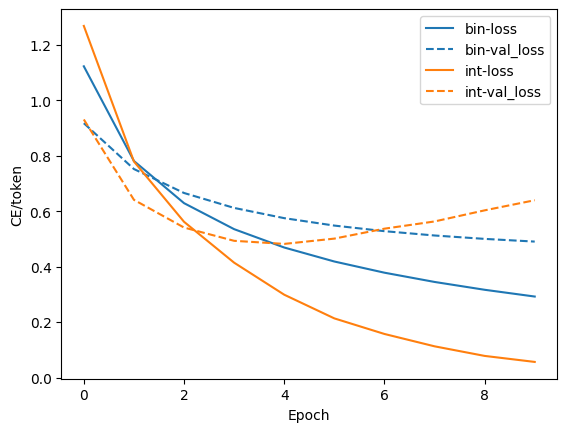

In [26]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

You are nearly ready to train your model.

As a final preprocessing step, you will apply the `TextVectorization` layers you created earlier to the training, validation, and test sets:

In [27]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

### Export the model

In [28]:
binary_model.export('bin.tf')

INFO:tensorflow:Assets written to: bin.tf/assets


INFO:tensorflow:Assets written to: bin.tf/assets


Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: string Tensor, shape=(None,)
  Returns:
    float32 Tensor, shape=(None, 4)


In [29]:
loaded = tf.saved_model.load('bin.tf')

In [30]:
binary_model.predict(['How do you sort a list?'])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 114ms/step


array([[-0.11534691,  0.01791038, -0.58859897,  0.3795665 ]],
      dtype=float32)

In [31]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.11534691,  0.01791038, -0.58859897,  0.3795665 ]],
      dtype=float32)


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply `tf.keras.layers.TextVectorization`. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the `TextVectorization` layer inside your model when you're ready to prepare for deployment.

Visit the [Save and load models](../keras/save_and_load.ipynb) tutorial to learn more about saving models.

<a name="example2">

## Example 2: Predict the author of Iliad translations

The following provides an example of using `tf.data.TextLineDataset` to load examples from text files, and [TensorFlow Text](https://www.tensorflow.org/text) to preprocess the data. You will use three different English translations of the same work, Homer's Iliad, and train a model to identify the translator given a single line of text.

To implement this task you'll use some lower level tools.

* You'll use `tf.data.TextLineDataset` to load text-lines from files.
* You'll implement your own version of `keras.layers.TextVectorization` using:
  * `text.UnicodeScriptTokenizer` - to convert strings to tokens.
  * `tf.lookup.StaticVocabularyTable` - to convert tokens to integer ids.
* You'll maximize performance by placing the text processing in the dataset pipeline, so it can run in parallel with the model training.

### Download and explore the dataset

The texts of the three translations are by:

- [William Cowper](https://en.wikipedia.org/wiki/William_Cowper): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/cowper.txt)
- [Edward, Earl of Derby](https://en.wikipedia.org/wiki/Edward_Smith-Stanley,_14th_Earl_of_Derby): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/derby.txt)
- [Samuel Butler](https://en.wikipedia.org/wiki/Samuel_Butler_%28novelist%29): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/butler.txt)

The text files used in this tutorial have undergone some typical preprocessing tasks like removing document header and footer, line numbers and chapter titles.

Download these lightly munged files locally:

In [32]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

  8192/815980 [..............................] - ETA: 0s

815980/815980 [==============================] - 0s 0us/step


  8192/809730 [..............................] - ETA: 0s

809730/809730 [==============================] - 0s 0us/step


  8192/807992 [..............................] - ETA: 0s

807992/807992 [==============================] - 0s 0us/step


[PosixPath('/home/kbuilder/.keras/datasets/flower_photos.tar'),
 PosixPath('/home/kbuilder/.keras/datasets/butler.txt'),
 PosixPath('/home/kbuilder/.keras/datasets/fashion-mnist'),
 PosixPath('/home/kbuilder/.keras/datasets/cowper.txt'),
 PosixPath('/home/kbuilder/.keras/datasets/flower_photos.tgz'),
 PosixPath('/home/kbuilder/.keras/datasets/mnist.npz'),
 PosixPath('/home/kbuilder/.keras/datasets/HIGGS.csv.gz'),
 PosixPath('/home/kbuilder/.keras/datasets/derby.txt'),
 PosixPath('/home/kbuilder/.keras/datasets/facades.tar.gz'),
 PosixPath('/home/kbuilder/.keras/datasets/train.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/jena_climate_2009_2016.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/iris_test.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/cats_and_dogs_filtered'),
 PosixPath('/home/kbuilder/.keras/datasets/jena_climate_2009_2016.csv.zip'),
 PosixPath('/home/kbuilder/.keras/datasets/heart.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/facades'),
 PosixPath('/home/kbu

### Load the dataset

Previously, with `tf.keras.utils.text_dataset_from_directory` all contents of a file were treated as a single example. Here, you will use `tf.data.TextLineDataset`, which is designed to create a `tf.data.Dataset` from a text file where each example is a line of text from the original file. `TextLineDataset` is useful for text data that is primarily line-based (for example, poetry or error logs).

Iterate through these files, loading each one into its own dataset. Each example needs to be individually labeled, so use `Dataset.map` to apply a labeler function to each one. This will iterate over every example in the dataset, returning (`example, label`) pairs.

In [33]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

In [34]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

Next, you'll combine these labeled datasets into a single dataset using `Dataset.concatenate`, and shuffle it with `Dataset.shuffle`:


In [35]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [36]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

Print out a few examples as before. The dataset hasn't been batched yet, hence each entry in `all_labeled_data` corresponds to one data point:

In [37]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'and Proto, Pherusa and Dynamene, Dexamene, Amphinome and Callianeira,'
Label: 2
Sentence:  b"Far from my sire and friends, in Lemnos' isle."
Label: 1
Sentence:  b'Sarpedon, as a lion on a herd:'
Label: 1
Sentence:  b'shook the dust from out of their manes, and bore their chariot swiftly'
Label: 2
Sentence:  b'with ease, had not Phoebus Apollo been angry, and in the guise of'
Label: 2
Sentence:  b'As may assuage Achilles, and prevail'
Label: 0
Sentence:  b'should have been hurled in vain, and withdrew under cover of his men.'
Label: 2
Sentence:  b'drove straight at Patroclus. Patroclus then sprang from his chariot to'
Label: 2
Sentence:  b"Me, Menela\xc3\xbcs, by Minerva's aid,"
Label: 0
Sentence:  b'As he spoke Patroclus put on his armour. First he greaved his legs with'
Label: 2


### Prepare the dataset for training

Instead of using `tf.keras.layers.TextVectorization` to preprocess the text dataset, you will now use the lower-level TensorFlow Text APIs to standardize and tokenize the data, build a vocabulary and use `tf.lookup.StaticVocabularyTable` to map tokens to integers to feed to the model. (Learn more about [TensorFlow Text](https://www.tensorflow.org/text)).

Define a function to convert the text to lower-case and tokenize it:

- TensorFlow Text provides various tokenizers. In this example, you will use the `text.UnicodeScriptTokenizer` to tokenize the dataset.
- You will use `Dataset.map` to apply the tokenization to the dataset.

In [38]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of strings, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # Convert to dense 0-padded.
      result = result.to_tensor()
    return result

In [39]:
tokenizer = MyTokenizer()

In [40]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

You can iterate over the dataset and print out a few tokenized examples:


In [41]:
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

tf.Tensor(
[b'and' b'proto' b',' b'pherusa' b'and' b'dynamene' b',' b'dexamene' b','
 b'amphinome' b'and' b'callianeira' b','], shape=(13,), dtype=string)

tf.Tensor(2, shape=(), dtype=int64)


Next, you will build a vocabulary by sorting tokens by frequency and keeping the top `VOCAB_SIZE` tokens:

In [42]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print("First five vocab entries:", vocab[:5])
print()

First five vocab entries: [b',', b'the', b'and', b"'", b'of']



To convert the tokens into integers, use the `vocab` set to create a `tf.lookup.StaticVocabularyTable`. You will map tokens to integers with `0` reserved for padding, and `n+1` reserved to denote an out-of-vocabulary (OOV) token.

In [43]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)

    num_oov_buckets = 1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result

Try it on a dummy vocabulary:

In [44]:
vocab_table = MyVocabTable(['a','b','c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 4, 4, 4, 4, 4])>

Create one for the real vocabulary:

In [45]:
vocab_table = MyVocabTable(vocab)

Finally, define a layer to standardize, tokenize and vectorize the dataset using the tokenizer and lookup table:

In [46]:
preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

You can try this on a single example to print the output:

In [47]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'and Proto, Pherusa and Dynamene, Dexamene, Amphinome and Callianeira,'
Vectorized sentence:  [   3 7805    1 7806    3 7807    1 7808    1 7809    3 9790    1]


Now create a dataset pipeline that will process the text on the fly using `Dataset.map`:

In [48]:
all_encoded_data = all_labeled_data.map(lambda text, labels:(preprocess_text(text), labels))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

Ids:  [   3 7805    1 7806    3 7807    1 7808    1 7809    3 9790    1]
Label:  2


### Split the dataset into training and test sets


The Keras `TextVectorization` layer also batches and pads the vectorized data. Padding is required because the examples inside of a batch need to be the same size and shape, but the examples in these datasets are not all the same size—each line of text has a different number of words.

`tf.data.Dataset` supports splitting and padded-batching datasets:

In [49]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

Now, `validation_data` and `train_data` are not collections of (`example, label`) pairs, but collections of batches. Each batch is a pair of (*many examples*, *many labels*) represented as arrays.

To illustrate this:

In [50]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 18)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[   3 7805    1 7806    3 7807    1 7808    1 7809    3 9790    1    0
    0    0    0    0], shape=(18,), dtype=int64)
First label example:  tf.Tensor(2, shape=(), dtype=int64)


Configure the datasets for better performance as before:

In [51]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

### Train the model

You can train a model on this dataset as before:

Since this text vectorization adds `0` for padding and `n+1` for out-of-vocabulary (OOV) tokens, the vocabulary size has increased by two:

In [52]:
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3)

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

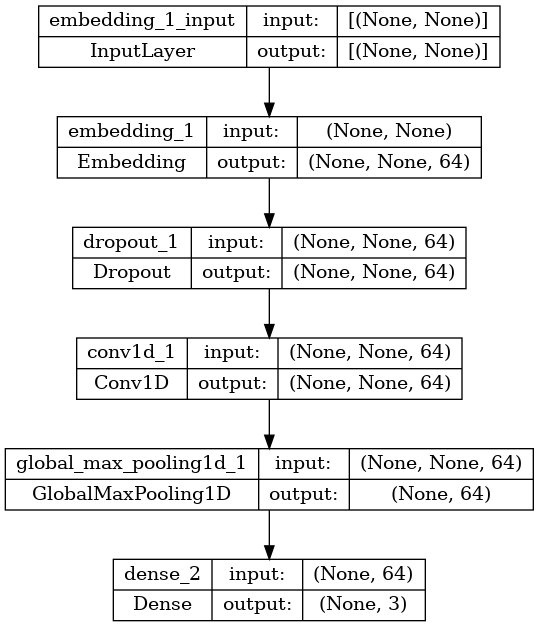

In [53]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
history = model.fit(train_data, validation_data=validation_data, epochs=3)

Epoch 1/3


      1/Unknown - 23s 23s/step - loss: 1.0808 - accuracy: 0.5312

      8/Unknown - 23s 8ms/step - loss: 1.0767 - accuracy: 0.4121

     17/Unknown - 23s 7ms/step - loss: 1.0590 - accuracy: 0.3943

     25/Unknown - 23s 7ms/step - loss: 1.0421 - accuracy: 0.4050

     33/Unknown - 23s 7ms/step - loss: 1.0340 - accuracy: 0.4029

     44/Unknown - 23s 6ms/step - loss: 1.0170 - accuracy: 0.4215

     54/Unknown - 23s 6ms/step - loss: 1.0054 - accuracy: 0.4340

     65/Unknown - 23s 6ms/step - loss: 0.9876 - accuracy: 0.4620

     75/Unknown - 23s 6ms/step - loss: 0.9712 - accuracy: 0.4777

     86/Unknown - 23s 6ms/step - loss: 0.9528 - accuracy: 0.4958

     97/Unknown - 23s 5ms/step - loss: 0.9315 - accuracy: 0.5129

    109/Unknown - 23s 5ms/step - loss: 0.9154 - accuracy: 0.5278

    121/Unknown - 23s 5ms/step - loss: 0.8988 - accuracy: 0.5384

    133/Unknown - 23s 5ms/step - loss: 0.8867 - accuracy: 0.5471

    145/Unknown - 23s 5ms/step - loss: 0.8735 - accuracy: 0.5554

    157/Unknown - 23s 5ms/step - loss: 0.8633 - accuracy: 0.5638

    169/Unknown - 23s 5ms/step - loss: 0.8517 - accuracy: 0.5734

    181/Unknown - 24s 5ms/step - loss: 0.8391 - accuracy: 0.5836

    193/Unknown - 24s 5ms/step - loss: 0.8263 - accuracy: 0.5917

    205/Unknown - 24s 5ms/step - loss: 0.8157 - accuracy: 0.6005

    217/Unknown - 24s 5ms/step - loss: 0.8039 - accuracy: 0.6088

    229/Unknown - 24s 5ms/step - loss: 0.7947 - accuracy: 0.6143

    241/Unknown - 24s 5ms/step - loss: 0.7860 - accuracy: 0.6205

    253/Unknown - 24s 5ms/step - loss: 0.7770 - accuracy: 0.6266

    265/Unknown - 24s 5ms/step - loss: 0.7673 - accuracy: 0.6321

    278/Unknown - 24s 5ms/step - loss: 0.7581 - accuracy: 0.6373

    290/Unknown - 24s 5ms/step - loss: 0.7483 - accuracy: 0.6430

    302/Unknown - 24s 5ms/step - loss: 0.7405 - accuracy: 0.6479

    314/Unknown - 24s 5ms/step - loss: 0.7324 - accuracy: 0.6532

    326/Unknown - 24s 5ms/step - loss: 0.7238 - accuracy: 0.6582

    339/Unknown - 24s 5ms/step - loss: 0.7146 - accuracy: 0.6632

    351/Unknown - 24s 5ms/step - loss: 0.7071 - accuracy: 0.6677

    363/Unknown - 24s 5ms/step - loss: 0.7010 - accuracy: 0.6715

    375/Unknown - 24s 5ms/step - loss: 0.6953 - accuracy: 0.6750

    387/Unknown - 24s 5ms/step - loss: 0.6890 - accuracy: 0.6787

    399/Unknown - 24s 5ms/step - loss: 0.6832 - accuracy: 0.6818

    411/Unknown - 24s 5ms/step - loss: 0.6769 - accuracy: 0.6853

    423/Unknown - 25s 5ms/step - loss: 0.6724 - accuracy: 0.6879

    436/Unknown - 25s 5ms/step - loss: 0.6665 - accuracy: 0.6910

    449/Unknown - 25s 4ms/step - loss: 0.6603 - accuracy: 0.6940

    461/Unknown - 25s 4ms/step - loss: 0.6557 - accuracy: 0.6961

    473/Unknown - 25s 4ms/step - loss: 0.6520 - accuracy: 0.6979

    485/Unknown - 25s 4ms/step - loss: 0.6475 - accuracy: 0.7006

    497/Unknown - 25s 4ms/step - loss: 0.6431 - accuracy: 0.7031

    509/Unknown - 25s 4ms/step - loss: 0.6386 - accuracy: 0.7055

    522/Unknown - 25s 4ms/step - loss: 0.6329 - accuracy: 0.7089

    535/Unknown - 25s 4ms/step - loss: 0.6281 - accuracy: 0.7117

    547/Unknown - 25s 4ms/step - loss: 0.6242 - accuracy: 0.7142

    559/Unknown - 25s 4ms/step - loss: 0.6212 - accuracy: 0.7161

    571/Unknown - 25s 4ms/step - loss: 0.6176 - accuracy: 0.7178

    583/Unknown - 25s 4ms/step - loss: 0.6153 - accuracy: 0.7191

    596/Unknown - 25s 4ms/step - loss: 0.6114 - accuracy: 0.7210

    608/Unknown - 25s 4ms/step - loss: 0.6080 - accuracy: 0.7228

    620/Unknown - 25s 4ms/step - loss: 0.6049 - accuracy: 0.7246

    632/Unknown - 25s 4ms/step - loss: 0.6020 - accuracy: 0.7262

    644/Unknown - 25s 4ms/step - loss: 0.5995 - accuracy: 0.7277

    656/Unknown - 26s 4ms/step - loss: 0.5974 - accuracy: 0.7288

    668/Unknown - 26s 4ms/step - loss: 0.5942 - accuracy: 0.7303

    680/Unknown - 26s 4ms/step - loss: 0.5910 - accuracy: 0.7319

    692/Unknown - 26s 4ms/step - loss: 0.5874 - accuracy: 0.7336

697/697 [==============================] - 30s 10ms/step - loss: 0.5868 - accuracy: 0.7339 - val_loss: 0.4017 - val_accuracy: 0.8302


Epoch 2/3


  1/697 [..............................] - ETA: 4:10:43 - loss: 0.5078 - accuracy: 0.7656

 13/697 [..............................] - ETA: 2s - loss: 0.3763 - accuracy: 0.8462     

 25/697 [>.............................] - ETA: 2s - loss: 0.3716 - accuracy: 0.8500

 37/697 [>.............................] - ETA: 2s - loss: 0.3800 - accuracy: 0.8476

 49/697 [=>............................] - ETA: 2s - loss: 0.3745 - accuracy: 0.8457

 61/697 [=>............................] - ETA: 2s - loss: 0.3731 - accuracy: 0.8463

 73/697 [==>...........................] - ETA: 2s - loss: 0.3712 - accuracy: 0.8491

 85/697 [==>...........................] - ETA: 2s - loss: 0.3705 - accuracy: 0.8493

 97/697 [===>..........................] - ETA: 2s - loss: 0.3748 - accuracy: 0.8457

109/697 [===>..........................] - ETA: 2s - loss: 0.3756 - accuracy: 0.8472

121/697 [====>.........................] - ETA: 2s - loss: 0.3736 - accuracy: 0.8479

133/697 [====>.........................] - ETA: 2s - loss: 0.3718 - accuracy: 0.8490

145/697 [=====>........................] - ETA: 2s - loss: 0.3717 - accuracy: 0.8484

157/697 [=====>........................] - ETA: 2s - loss: 0.3719 - accuracy: 0.8477

169/697 [======>.......................] - ETA: 2s - loss: 0.3726 - accuracy: 0.8468

181/697 [======>.......................] - ETA: 2s - loss: 0.3708 - accuracy: 0.8472

193/697 [=======>......................] - ETA: 2s - loss: 0.3723 - accuracy: 0.8467

205/697 [=======>......................] - ETA: 2s - loss: 0.3708 - accuracy: 0.8479

217/697 [========>.....................] - ETA: 2s - loss: 0.3696 - accuracy: 0.8481

229/697 [========>.....................] - ETA: 2s - loss: 0.3677 - accuracy: 0.8485

241/697 [=========>....................] - ETA: 1s - loss: 0.3671 - accuracy: 0.8496

253/697 [=========>....................] - ETA: 1s - loss: 0.3672 - accuracy: 0.8501

265/697 [==========>...................] - ETA: 1s - loss: 0.3676 - accuracy: 0.8496

277/697 [==========>...................] - ETA: 1s - loss: 0.3665 - accuracy: 0.8491

289/697 [===========>..................] - ETA: 1s - loss: 0.3668 - accuracy: 0.8490

301/697 [===========>..................] - ETA: 1s - loss: 0.3677 - accuracy: 0.8483

313/697 [============>.................] - ETA: 1s - loss: 0.3675 - accuracy: 0.8482

325/697 [============>.................] - ETA: 1s - loss: 0.3682 - accuracy: 0.8483

337/697 [=============>................] - ETA: 1s - loss: 0.3685 - accuracy: 0.8480

349/697 [==============>...............] - ETA: 1s - loss: 0.3684 - accuracy: 0.8485

361/697 [==============>...............] - ETA: 1s - loss: 0.3680 - accuracy: 0.8483

373/697 [===============>..............] - ETA: 1s - loss: 0.3667 - accuracy: 0.8485

385/697 [===============>..............] - ETA: 1s - loss: 0.3668 - accuracy: 0.8480

397/697 [================>.............] - ETA: 1s - loss: 0.3661 - accuracy: 0.8486

409/697 [================>.............] - ETA: 1s - loss: 0.3666 - accuracy: 0.8481

421/697 [=================>............] - ETA: 1s - loss: 0.3668 - accuracy: 0.8481

433/697 [=================>............] - ETA: 1s - loss: 0.3665 - accuracy: 0.8479

445/697 [==================>...........] - ETA: 1s - loss: 0.3659 - accuracy: 0.8484

457/697 [==================>...........] - ETA: 1s - loss: 0.3673 - accuracy: 0.8477

469/697 [===================>..........] - ETA: 0s - loss: 0.3672 - accuracy: 0.8474

481/697 [===================>..........] - ETA: 0s - loss: 0.3674 - accuracy: 0.8475

493/697 [====================>.........] - ETA: 0s - loss: 0.3674 - accuracy: 0.8475

505/697 [====================>.........] - ETA: 0s - loss: 0.3672 - accuracy: 0.8476

517/697 [=====================>........] - ETA: 0s - loss: 0.3666 - accuracy: 0.8479

529/697 [=====================>........] - ETA: 0s - loss: 0.3671 - accuracy: 0.8477

541/697 [======================>.......] - ETA: 0s - loss: 0.3666 - accuracy: 0.8478

553/697 [======================>.......] - ETA: 0s - loss: 0.3660 - accuracy: 0.8482

565/697 [=======================>......] - ETA: 0s - loss: 0.3664 - accuracy: 0.8480

577/697 [=======================>......] - ETA: 0s - loss: 0.3656 - accuracy: 0.8485

589/697 [========================>.....] - ETA: 0s - loss: 0.3654 - accuracy: 0.8486

601/697 [========================>.....] - ETA: 0s - loss: 0.3647 - accuracy: 0.8489

613/697 [=========================>....] - ETA: 0s - loss: 0.3651 - accuracy: 0.8489

625/697 [=========================>....] - ETA: 0s - loss: 0.3656 - accuracy: 0.8487

637/697 [==========================>...] - ETA: 0s - loss: 0.3650 - accuracy: 0.8490

649/697 [==========================>...] - ETA: 0s - loss: 0.3646 - accuracy: 0.8491

661/697 [===========================>..] - ETA: 0s - loss: 0.3649 - accuracy: 0.8489

673/697 [===========================>..] - ETA: 0s - loss: 0.3645 - accuracy: 0.8488

685/697 [============================>.] - ETA: 0s - loss: 0.3641 - accuracy: 0.8489

697/697 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8489

697/697 [==============================] - 28s 10ms/step - loss: 0.3642 - accuracy: 0.8489 - val_loss: 0.3574 - val_accuracy: 0.8472


Epoch 3/3


  1/697 [..............................] - ETA: 4:17:33 - loss: 0.3495 - accuracy: 0.8438

 13/697 [..............................] - ETA: 3s - loss: 0.2834 - accuracy: 0.8750     

 25/697 [>.............................] - ETA: 2s - loss: 0.2817 - accuracy: 0.8844

 38/697 [>.............................] - ETA: 2s - loss: 0.2917 - accuracy: 0.8845

 50/697 [=>............................] - ETA: 2s - loss: 0.2861 - accuracy: 0.8825

 62/697 [=>............................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8843

 74/697 [==>...........................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8847

 86/697 [==>...........................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8846

 98/697 [===>..........................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8850

111/697 [===>..........................] - ETA: 2s - loss: 0.2899 - accuracy: 0.8846

123/697 [====>.........................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8855

135/697 [====>.........................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8858

146/697 [=====>........................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8850

158/697 [=====>........................] - ETA: 2s - loss: 0.2869 - accuracy: 0.8847

170/697 [======>.......................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8832

182/697 [======>.......................] - ETA: 2s - loss: 0.2897 - accuracy: 0.8831

194/697 [=======>......................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8823

207/697 [=======>......................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8824

220/697 [========>.....................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8829

232/697 [========>.....................] - ETA: 1s - loss: 0.2880 - accuracy: 0.8832

244/697 [=========>....................] - ETA: 1s - loss: 0.2893 - accuracy: 0.8822

256/697 [==========>...................] - ETA: 1s - loss: 0.2889 - accuracy: 0.8828

268/697 [==========>...................] - ETA: 1s - loss: 0.2879 - accuracy: 0.8831

280/697 [===========>..................] - ETA: 1s - loss: 0.2884 - accuracy: 0.8824

292/697 [===========>..................] - ETA: 1s - loss: 0.2888 - accuracy: 0.8814

304/697 [============>.................] - ETA: 1s - loss: 0.2897 - accuracy: 0.8812

316/697 [============>.................] - ETA: 1s - loss: 0.2909 - accuracy: 0.8812

328/697 [=============>................] - ETA: 1s - loss: 0.2908 - accuracy: 0.8810

340/697 [=============>................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8808

352/697 [==============>...............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8804

364/697 [==============>...............] - ETA: 1s - loss: 0.2912 - accuracy: 0.8807

376/697 [===============>..............] - ETA: 1s - loss: 0.2899 - accuracy: 0.8816

388/697 [===============>..............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8818

401/697 [================>.............] - ETA: 1s - loss: 0.2897 - accuracy: 0.8821

413/697 [================>.............] - ETA: 1s - loss: 0.2893 - accuracy: 0.8823

425/697 [=================>............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8814

437/697 [=================>............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8817

449/697 [==================>...........] - ETA: 1s - loss: 0.2906 - accuracy: 0.8819

461/697 [==================>...........] - ETA: 1s - loss: 0.2915 - accuracy: 0.8815

473/697 [===================>..........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8813

485/697 [===================>..........] - ETA: 0s - loss: 0.2905 - accuracy: 0.8817

497/697 [====================>.........] - ETA: 0s - loss: 0.2910 - accuracy: 0.8813

509/697 [====================>.........] - ETA: 0s - loss: 0.2920 - accuracy: 0.8805

521/697 [=====================>........] - ETA: 0s - loss: 0.2914 - accuracy: 0.8807

533/697 [=====================>........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8810

545/697 [======================>.......] - ETA: 0s - loss: 0.2903 - accuracy: 0.8811

557/697 [======================>.......] - ETA: 0s - loss: 0.2901 - accuracy: 0.8811

570/697 [=======================>......] - ETA: 0s - loss: 0.2908 - accuracy: 0.8810

582/697 [========================>.....] - ETA: 0s - loss: 0.2916 - accuracy: 0.8808

595/697 [========================>.....] - ETA: 0s - loss: 0.2908 - accuracy: 0.8810

608/697 [=========================>....] - ETA: 0s - loss: 0.2917 - accuracy: 0.8806

620/697 [=========================>....] - ETA: 0s - loss: 0.2910 - accuracy: 0.8807

632/697 [==========================>...] - ETA: 0s - loss: 0.2918 - accuracy: 0.8806

644/697 [==========================>...] - ETA: 0s - loss: 0.2911 - accuracy: 0.8807

656/697 [===========================>..] - ETA: 0s - loss: 0.2912 - accuracy: 0.8808

668/697 [===========================>..] - ETA: 0s - loss: 0.2917 - accuracy: 0.8807

680/697 [============================>.] - ETA: 0s - loss: 0.2909 - accuracy: 0.8811

692/697 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8808

697/697 [==============================] - 29s 9ms/step - loss: 0.2910 - accuracy: 0.8808 - val_loss: 0.3527 - val_accuracy: 0.8506


In [55]:
metrics = model.evaluate(validation_data, return_dict=True)

print("Loss: ", metrics['loss'])
print("Accuracy: {:2.2%}".format(metrics['accuracy']))

      1/Unknown - 1s 1s/step - loss: 0.3171 - accuracy: 0.8906

      3/Unknown - 1s 33ms/step - loss: 0.3394 - accuracy: 0.8438

      5/Unknown - 1s 32ms/step - loss: 0.3616 - accuracy: 0.8406

      7/Unknown - 1s 31ms/step - loss: 0.3426 - accuracy: 0.8549

      9/Unknown - 1s 31ms/step - loss: 0.3073 - accuracy: 0.8767

     11/Unknown - 1s 31ms/step - loss: 0.3027 - accuracy: 0.8764

     13/Unknown - 2s 30ms/step - loss: 0.3126 - accuracy: 0.8678

     15/Unknown - 2s 30ms/step - loss: 0.3169 - accuracy: 0.8656

     17/Unknown - 2s 30ms/step - loss: 0.3212 - accuracy: 0.8649

     19/Unknown - 2s 30ms/step - loss: 0.3274 - accuracy: 0.8651

     21/Unknown - 2s 30ms/step - loss: 0.3376 - accuracy: 0.8616

     23/Unknown - 2s 30ms/step - loss: 0.3418 - accuracy: 0.8560

     25/Unknown - 2s 30ms/step - loss: 0.3435 - accuracy: 0.8550

     27/Unknown - 2s 30ms/step - loss: 0.3505 - accuracy: 0.8513

     29/Unknown - 2s 30ms/step - loss: 0.3523 - accuracy: 0.8491

     31/Unknown - 2s 29ms/step - loss: 0.3538 - accuracy: 0.8503

     33/Unknown - 2s 29ms/step - loss: 0.3568 - accuracy: 0.8485

     35/Unknown - 2s 29ms/step - loss: 0.3621 - accuracy: 0.8473

     37/Unknown - 2s 29ms/step - loss: 0.3627 - accuracy: 0.8459

     39/Unknown - 2s 29ms/step - loss: 0.3605 - accuracy: 0.8478

     41/Unknown - 2s 29ms/step - loss: 0.3591 - accuracy: 0.8464

     43/Unknown - 2s 29ms/step - loss: 0.3546 - accuracy: 0.8492

     45/Unknown - 2s 29ms/step - loss: 0.3549 - accuracy: 0.8490

     47/Unknown - 2s 29ms/step - loss: 0.3567 - accuracy: 0.8497

     49/Unknown - 3s 29ms/step - loss: 0.3570 - accuracy: 0.8492

     51/Unknown - 3s 29ms/step - loss: 0.3519 - accuracy: 0.8514

     53/Unknown - 3s 29ms/step - loss: 0.3558 - accuracy: 0.8494

     55/Unknown - 3s 29ms/step - loss: 0.3581 - accuracy: 0.8489

     57/Unknown - 3s 29ms/step - loss: 0.3550 - accuracy: 0.8506

     59/Unknown - 3s 29ms/step - loss: 0.3553 - accuracy: 0.8506

     61/Unknown - 3s 29ms/step - loss: 0.3557 - accuracy: 0.8496

     63/Unknown - 3s 29ms/step - loss: 0.3583 - accuracy: 0.8480

     65/Unknown - 3s 29ms/step - loss: 0.3569 - accuracy: 0.8490

     67/Unknown - 3s 29ms/step - loss: 0.3563 - accuracy: 0.8496

     69/Unknown - 3s 29ms/step - loss: 0.3558 - accuracy: 0.8503

     71/Unknown - 3s 29ms/step - loss: 0.3569 - accuracy: 0.8497

     73/Unknown - 3s 29ms/step - loss: 0.3555 - accuracy: 0.8495

     75/Unknown - 3s 29ms/step - loss: 0.3537 - accuracy: 0.8506

     77/Unknown - 3s 29ms/step - loss: 0.3540 - accuracy: 0.8504

79/79 [==============================] - 3s 29ms/step - loss: 0.3527 - accuracy: 0.8506


Loss:  0.35271939635276794
Accuracy: 85.06%


### Export the model

To make the model capable of taking raw strings as input, pack both the text processor and the model into a `keras.Sequential`:

In [56]:
export_model = tf.keras.Sequential([
    preprocess_text,
    model
])

In [57]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

This model you can run directly on batches of strings:

In [58]:
# Create a test dataset of raw strings.
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [59]:
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

      1/Unknown - 5s 5s/step - loss: 1.2408 - accuracy: 0.8906

      7/Unknown - 5s 9ms/step - loss: 1.0326 - accuracy: 0.8549

     13/Unknown - 5s 9ms/step - loss: 0.7683 - accuracy: 0.8678

     20/Unknown - 5s 8ms/step - loss: 0.9390 - accuracy: 0.8641

     27/Unknown - 5s 8ms/step - loss: 0.9695 - accuracy: 0.8513

     34/Unknown - 5s 8ms/step - loss: 1.0241 - accuracy: 0.8483

     41/Unknown - 5s 8ms/step - loss: 1.0335 - accuracy: 0.8464

     48/Unknown - 5s 8ms/step - loss: 1.0343 - accuracy: 0.8493

     55/Unknown - 5s 8ms/step - loss: 1.0255 - accuracy: 0.8489

     61/Unknown - 5s 8ms/step - loss: 1.0324 - accuracy: 0.8496

     68/Unknown - 5s 8ms/step - loss: 1.0353 - accuracy: 0.8497

     75/Unknown - 5s 8ms/step - loss: 1.0337 - accuracy: 0.8506

79/79 [==============================] - 5s 9ms/step - loss: 1.0300 - accuracy: 0.8506


Loss:  1.0299931764602661
Accuracy: 85.06%


Use `saved_model.save` to export it.

<!-- TODO: After 2.15 switch this to use Model.export -->

In [60]:
tf.saved_model.save(export_model, 'export.tf')

INFO:tensorflow:Assets written to: export.tf/assets


INFO:tensorflow:Assets written to: export.tf/assets


In [61]:
loaded = tf.saved_model.load('export.tf')

In [62]:
export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

array([[-3.2765586 , -0.37794957,  3.0517902 ]], dtype=float32)

In [63]:
loaded(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

2024-08-16 07:41:04.103166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/StatefulPartitionedCall/sequential_2/StatefulPartitionedCall/my_tokenizer/UnicodeScriptTokenize/RaggedConcat/assert_equal_1/Assert/AssertGuard/branch_executed/_42


array([[-3.2765586 , -0.37794957,  3.0517902 ]], dtype=float32)

The loss and accuracy for the model on encoded validation set and the exported model on the raw validation set are the same, as expected.

### Run inference on new data

In [64]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


Question:  Join'd to th' Ionians with their flowing robes,
Predicted label:  1
Question:  the allies, and his armour flashed about him so that he seemed to all
Predicted label:  2
Question:  And with loud clangor of his arms he fell.
Predicted label:  0


## Download more datasets using TensorFlow Datasets (TFDS)


You can download many more datasets from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview).

In this example, you will use the [IMDB Large Movie Review dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) to train a model for sentiment classification:

In [65]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [66]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

Print a few examples:

In [67]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print("Review: ", review_batch[i].numpy())
    print("Label: ", label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

You can now preprocess the data and train a model as before.

Note: You will use `tf.keras.losses.BinaryCrossentropy` instead of `tf.keras.losses.SparseCategoricalCrossentropy` for your model, since this is a binary classification problem.

### Prepare the dataset for training

In [68]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [69]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [70]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [71]:
# Configure datasets for performance as before.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

### Create, configure and train the model

In [72]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding_2 (Embedding)     (None, None, 64)          640000    


 dropout_2 (Dropout)         (None, None, 64)          0         


 conv1d_2 (Conv1D)           (None, None, 64)          20544     


 global_max_pooling1d_2 (Gl  (None, 64)                0         


 obalMaxPooling1D)                                               


 dense_3 (Dense)             (None, 1)                 65        


Total params: 660609 (2.52 MB)


Trainable params: 660609 (2.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [73]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [74]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


  1/313 [..............................] - ETA: 4:37 - loss: 0.6916 - accuracy: 0.5156

  6/313 [..............................] - ETA: 3s - loss: 0.6932 - accuracy: 0.4922  

 12/313 [>.............................] - ETA: 3s - loss: 0.6924 - accuracy: 0.4818

 18/313 [>.............................] - ETA: 2s - loss: 0.6929 - accuracy: 0.4931

 24/313 [=>............................] - ETA: 2s - loss: 0.6926 - accuracy: 0.4896

 30/313 [=>............................] - ETA: 2s - loss: 0.6925 - accuracy: 0.4995

 36/313 [==>...........................] - ETA: 2s - loss: 0.6923 - accuracy: 0.5056

 42/313 [===>..........................] - ETA: 2s - loss: 0.6925 - accuracy: 0.5004

 48/313 [===>..........................] - ETA: 2s - loss: 0.6925 - accuracy: 0.4997

 54/313 [====>.........................] - ETA: 2s - loss: 0.6921 - accuracy: 0.5006

 60/313 [====>.........................] - ETA: 2s - loss: 0.6920 - accuracy: 0.4995

 66/313 [=====>........................] - ETA: 2s - loss: 0.6916 - accuracy: 0.4941

 72/313 [=====>........................] - ETA: 2s - loss: 0.6914 - accuracy: 0.4915

 78/313 [======>.......................] - ETA: 2s - loss: 0.6914 - accuracy: 0.4940

 84/313 [=======>......................] - ETA: 2s - loss: 0.6911 - accuracy: 0.4952

 90/313 [=======>......................] - ETA: 2s - loss: 0.6909 - accuracy: 0.4986

 96/313 [========>.....................] - ETA: 2s - loss: 0.6904 - accuracy: 0.4990

102/313 [========>.....................] - ETA: 1s - loss: 0.6897 - accuracy: 0.4997

108/313 [=========>....................] - ETA: 1s - loss: 0.6894 - accuracy: 0.4971

114/313 [=========>....................] - ETA: 1s - loss: 0.6886 - accuracy: 0.4973

120/313 [==========>...................] - ETA: 1s - loss: 0.6878 - accuracy: 0.4996

126/313 [===========>..................] - ETA: 1s - loss: 0.6867 - accuracy: 0.4985

132/313 [===========>..................] - ETA: 1s - loss: 0.6856 - accuracy: 0.5006

138/313 [============>.................] - ETA: 1s - loss: 0.6842 - accuracy: 0.5018

144/313 [============>.................] - ETA: 1s - loss: 0.6829 - accuracy: 0.5015

150/313 [=============>................] - ETA: 1s - loss: 0.6812 - accuracy: 0.5008

156/313 [=============>................] - ETA: 1s - loss: 0.6789 - accuracy: 0.5000

162/313 [==============>...............] - ETA: 1s - loss: 0.6764 - accuracy: 0.4997

168/313 [===============>..............] - ETA: 1s - loss: 0.6749 - accuracy: 0.5034

174/313 [===============>..............] - ETA: 1s - loss: 0.6723 - accuracy: 0.5051

180/313 [================>.............] - ETA: 1s - loss: 0.6695 - accuracy: 0.5067

186/313 [================>.............] - ETA: 1s - loss: 0.6672 - accuracy: 0.5094

192/313 [=================>............] - ETA: 1s - loss: 0.6642 - accuracy: 0.5157

198/313 [=================>............] - ETA: 1s - loss: 0.6607 - accuracy: 0.5215

204/313 [==================>...........] - ETA: 1s - loss: 0.6569 - accuracy: 0.5281

210/313 [===================>..........] - ETA: 0s - loss: 0.6544 - accuracy: 0.5337

216/313 [===================>..........] - ETA: 0s - loss: 0.6506 - accuracy: 0.5402

222/313 [====================>.........] - ETA: 0s - loss: 0.6462 - accuracy: 0.5464

228/313 [====================>.........] - ETA: 0s - loss: 0.6428 - accuracy: 0.5519

234/313 [=====================>........] - ETA: 0s - loss: 0.6391 - accuracy: 0.5580

240/313 [======================>.......] - ETA: 0s - loss: 0.6348 - accuracy: 0.5635

246/313 [======================>.......] - ETA: 0s - loss: 0.6306 - accuracy: 0.5683

252/313 [=======================>......] - ETA: 0s - loss: 0.6277 - accuracy: 0.5728

258/313 [=======================>......] - ETA: 0s - loss: 0.6241 - accuracy: 0.5773

264/313 [========================>.....] - ETA: 0s - loss: 0.6203 - accuracy: 0.5821

269/313 [========================>.....] - ETA: 0s - loss: 0.6184 - accuracy: 0.5852

274/313 [=========================>....] - ETA: 0s - loss: 0.6157 - accuracy: 0.5885

279/313 [=========================>....] - ETA: 0s - loss: 0.6133 - accuracy: 0.5920

285/313 [==========================>...] - ETA: 0s - loss: 0.6104 - accuracy: 0.5956

291/313 [==========================>...] - ETA: 0s - loss: 0.6065 - accuracy: 0.6004

297/313 [===========================>..] - ETA: 0s - loss: 0.6044 - accuracy: 0.6034

303/313 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.6071

309/313 [============================>.] - ETA: 0s - loss: 0.5984 - accuracy: 0.6103

313/313 [==============================] - 5s 12ms/step - loss: 0.5965 - accuracy: 0.6120 - val_loss: 0.4267 - val_accuracy: 0.7970


Epoch 2/3


  1/313 [..............................] - ETA: 3s - loss: 0.5233 - accuracy: 0.7500

  7/313 [..............................] - ETA: 2s - loss: 0.4360 - accuracy: 0.8058

 13/313 [>.............................] - ETA: 2s - loss: 0.4308 - accuracy: 0.7981

 19/313 [>.............................] - ETA: 2s - loss: 0.4350 - accuracy: 0.7969

 25/313 [=>............................] - ETA: 2s - loss: 0.4322 - accuracy: 0.7881

 31/313 [=>............................] - ETA: 2s - loss: 0.4325 - accuracy: 0.7888

 37/313 [==>...........................] - ETA: 2s - loss: 0.4210 - accuracy: 0.7960

 43/313 [===>..........................] - ETA: 2s - loss: 0.4197 - accuracy: 0.7991

 49/313 [===>..........................] - ETA: 2s - loss: 0.4188 - accuracy: 0.7997

 55/313 [====>.........................] - ETA: 2s - loss: 0.4197 - accuracy: 0.8003

 61/313 [====>.........................] - ETA: 2s - loss: 0.4188 - accuracy: 0.8010

 67/313 [=====>........................] - ETA: 2s - loss: 0.4180 - accuracy: 0.7987

 73/313 [=====>........................] - ETA: 2s - loss: 0.4188 - accuracy: 0.7992

 79/313 [======>.......................] - ETA: 2s - loss: 0.4173 - accuracy: 0.7998

 85/313 [=======>......................] - ETA: 2s - loss: 0.4156 - accuracy: 0.8015

 91/313 [=======>......................] - ETA: 2s - loss: 0.4120 - accuracy: 0.8036

 97/313 [========>.....................] - ETA: 2s - loss: 0.4086 - accuracy: 0.8049

103/313 [========>.....................] - ETA: 1s - loss: 0.4077 - accuracy: 0.8060

109/313 [=========>....................] - ETA: 1s - loss: 0.4088 - accuracy: 0.8063

115/313 [==========>...................] - ETA: 1s - loss: 0.4058 - accuracy: 0.8090

121/313 [==========>...................] - ETA: 1s - loss: 0.4074 - accuracy: 0.8090

127/313 [===========>..................] - ETA: 1s - loss: 0.4071 - accuracy: 0.8088

133/313 [===========>..................] - ETA: 1s - loss: 0.4046 - accuracy: 0.8107

139/313 [============>.................] - ETA: 1s - loss: 0.4033 - accuracy: 0.8119

145/313 [============>.................] - ETA: 1s - loss: 0.4026 - accuracy: 0.8112

151/313 [=============>................] - ETA: 1s - loss: 0.3998 - accuracy: 0.8128

157/313 [==============>...............] - ETA: 1s - loss: 0.3986 - accuracy: 0.8129

163/313 [==============>...............] - ETA: 1s - loss: 0.3982 - accuracy: 0.8137

169/313 [===============>..............] - ETA: 1s - loss: 0.3990 - accuracy: 0.8129

175/313 [===============>..............] - ETA: 1s - loss: 0.3971 - accuracy: 0.8137

180/313 [================>.............] - ETA: 1s - loss: 0.3960 - accuracy: 0.8148

186/313 [================>.............] - ETA: 1s - loss: 0.3969 - accuracy: 0.8148

192/313 [=================>............] - ETA: 1s - loss: 0.3957 - accuracy: 0.8160

198/313 [=================>............] - ETA: 1s - loss: 0.3936 - accuracy: 0.8166

204/313 [==================>...........] - ETA: 0s - loss: 0.3930 - accuracy: 0.8166

210/313 [===================>..........] - ETA: 0s - loss: 0.3930 - accuracy: 0.8169

216/313 [===================>..........] - ETA: 0s - loss: 0.3910 - accuracy: 0.8173

222/313 [====================>.........] - ETA: 0s - loss: 0.3894 - accuracy: 0.8183

228/313 [====================>.........] - ETA: 0s - loss: 0.3875 - accuracy: 0.8192

234/313 [=====================>........] - ETA: 0s - loss: 0.3861 - accuracy: 0.8206

240/313 [======================>.......] - ETA: 0s - loss: 0.3840 - accuracy: 0.8223

246/313 [======================>.......] - ETA: 0s - loss: 0.3824 - accuracy: 0.8234

252/313 [=======================>......] - ETA: 0s - loss: 0.3823 - accuracy: 0.8238

258/313 [=======================>......] - ETA: 0s - loss: 0.3809 - accuracy: 0.8247

264/313 [========================>.....] - ETA: 0s - loss: 0.3790 - accuracy: 0.8258

270/313 [========================>.....] - ETA: 0s - loss: 0.3792 - accuracy: 0.8257

276/313 [=========================>....] - ETA: 0s - loss: 0.3782 - accuracy: 0.8263

282/313 [==========================>...] - ETA: 0s - loss: 0.3771 - accuracy: 0.8270

288/313 [==========================>...] - ETA: 0s - loss: 0.3765 - accuracy: 0.8277

294/313 [===========================>..] - ETA: 0s - loss: 0.3750 - accuracy: 0.8283

299/313 [===========================>..] - ETA: 0s - loss: 0.3746 - accuracy: 0.8284

305/313 [============================>.] - ETA: 0s - loss: 0.3739 - accuracy: 0.8289

311/313 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8298

313/313 [==============================] - 3s 10ms/step - loss: 0.3725 - accuracy: 0.8299 - val_loss: 0.3418 - val_accuracy: 0.8454


Epoch 3/3


  1/313 [..............................] - ETA: 3s - loss: 0.4751 - accuracy: 0.7812

  7/313 [..............................] - ETA: 2s - loss: 0.3500 - accuracy: 0.8504

 13/313 [>.............................] - ETA: 2s - loss: 0.3312 - accuracy: 0.8522

 19/313 [>.............................] - ETA: 2s - loss: 0.3273 - accuracy: 0.8520

 25/313 [=>............................] - ETA: 2s - loss: 0.3250 - accuracy: 0.8544

 31/313 [=>............................] - ETA: 2s - loss: 0.3236 - accuracy: 0.8543

 37/313 [==>...........................] - ETA: 2s - loss: 0.3152 - accuracy: 0.8594

 43/313 [===>..........................] - ETA: 2s - loss: 0.3134 - accuracy: 0.8597

 48/313 [===>..........................] - ETA: 2s - loss: 0.3117 - accuracy: 0.8613

 54/313 [====>.........................] - ETA: 2s - loss: 0.3116 - accuracy: 0.8634

 59/313 [====>.........................] - ETA: 2s - loss: 0.3135 - accuracy: 0.8618

 65/313 [=====>........................] - ETA: 2s - loss: 0.3146 - accuracy: 0.8589

 71/313 [=====>........................] - ETA: 2s - loss: 0.3156 - accuracy: 0.8589

 77/313 [======>.......................] - ETA: 2s - loss: 0.3147 - accuracy: 0.8602

 83/313 [======>.......................] - ETA: 2s - loss: 0.3156 - accuracy: 0.8611

 89/313 [=======>......................] - ETA: 2s - loss: 0.3132 - accuracy: 0.8618

 94/313 [========>.....................] - ETA: 2s - loss: 0.3102 - accuracy: 0.8629

100/313 [========>.....................] - ETA: 2s - loss: 0.3075 - accuracy: 0.8642

106/313 [=========>....................] - ETA: 1s - loss: 0.3049 - accuracy: 0.8659

112/313 [=========>....................] - ETA: 1s - loss: 0.3055 - accuracy: 0.8647

118/313 [==========>...................] - ETA: 1s - loss: 0.3065 - accuracy: 0.8645

124/313 [==========>...................] - ETA: 1s - loss: 0.3068 - accuracy: 0.8647

130/313 [===========>..................] - ETA: 1s - loss: 0.3068 - accuracy: 0.8645

136/313 [============>.................] - ETA: 1s - loss: 0.3055 - accuracy: 0.8659

142/313 [============>.................] - ETA: 1s - loss: 0.3044 - accuracy: 0.8674

148/313 [=============>................] - ETA: 1s - loss: 0.3018 - accuracy: 0.8681

154/313 [=============>................] - ETA: 1s - loss: 0.3008 - accuracy: 0.8689

160/313 [==============>...............] - ETA: 1s - loss: 0.3006 - accuracy: 0.8689

166/313 [==============>...............] - ETA: 1s - loss: 0.3028 - accuracy: 0.8683

172/313 [===============>..............] - ETA: 1s - loss: 0.3019 - accuracy: 0.8680

178/313 [================>.............] - ETA: 1s - loss: 0.3001 - accuracy: 0.8694

183/313 [================>.............] - ETA: 1s - loss: 0.3007 - accuracy: 0.8684

188/313 [=================>............] - ETA: 1s - loss: 0.3005 - accuracy: 0.8690

194/313 [=================>............] - ETA: 1s - loss: 0.3001 - accuracy: 0.8693

200/313 [==================>...........] - ETA: 1s - loss: 0.3003 - accuracy: 0.8690

206/313 [==================>...........] - ETA: 0s - loss: 0.2994 - accuracy: 0.8691

212/313 [===================>..........] - ETA: 0s - loss: 0.2985 - accuracy: 0.8695

218/313 [===================>..........] - ETA: 0s - loss: 0.2974 - accuracy: 0.8701

224/313 [====================>.........] - ETA: 0s - loss: 0.2959 - accuracy: 0.8710

230/313 [=====================>........] - ETA: 0s - loss: 0.2948 - accuracy: 0.8717

236/313 [=====================>........] - ETA: 0s - loss: 0.2937 - accuracy: 0.8725

242/313 [======================>.......] - ETA: 0s - loss: 0.2926 - accuracy: 0.8728

248/313 [======================>.......] - ETA: 0s - loss: 0.2920 - accuracy: 0.8733

254/313 [=======================>......] - ETA: 0s - loss: 0.2917 - accuracy: 0.8738

260/313 [=======================>......] - ETA: 0s - loss: 0.2904 - accuracy: 0.8742

266/313 [========================>.....] - ETA: 0s - loss: 0.2895 - accuracy: 0.8748

272/313 [=========================>....] - ETA: 0s - loss: 0.2905 - accuracy: 0.8747

278/313 [=========================>....] - ETA: 0s - loss: 0.2890 - accuracy: 0.8757

284/313 [==========================>...] - ETA: 0s - loss: 0.2882 - accuracy: 0.8761

290/313 [==========================>...] - ETA: 0s - loss: 0.2875 - accuracy: 0.8765

296/313 [===========================>..] - ETA: 0s - loss: 0.2864 - accuracy: 0.8771

302/313 [===========================>..] - ETA: 0s - loss: 0.2855 - accuracy: 0.8778

308/313 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8778

313/313 [==============================] - 3s 10ms/step - loss: 0.2846 - accuracy: 0.8781 - val_loss: 0.3165 - val_accuracy: 0.8584


In [75]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

 1/79 [..............................] - ETA: 0s - loss: 0.2093 - accuracy: 0.9219

26/79 [========>.....................] - ETA: 0s - loss: 0.3243 - accuracy: 0.8612

51/79 [==================>...........] - ETA: 0s - loss: 0.3186 - accuracy: 0.8569

76/79 [===========================>..] - ETA: 0s - loss: 0.3142 - accuracy: 0.8596

79/79 [==============================] - 0s 2ms/step - loss: 0.3165 - accuracy: 0.8584


Loss:  0.3165397047996521
Accuracy: 85.84%


### Export the model

In [76]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [77]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]

predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 100ms/step


Question:  This is a fantastic movie.
Predicted label:  1
Question:  This is a bad movie.
Predicted label:  0
Question:  This movie was so bad that it was good.
Predicted label:  0
Question:  I will never say yes to watching this movie.
Predicted label:  1


## Conclusion

This tutorial demonstrated several ways to load and preprocess text. As a next step, you can explore additional text preprocessing [TensorFlow Text](https://www.tensorflow.org/text) tutorials, such as:

- [BERT Preprocessing with TF Text](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
- [Tokenizing with TF Text](https://www.tensorflow.org/text/guide/tokenizers)
- [Subword tokenizers](https://www.tensorflow.org/text/guide/subwords_tokenizer)

You can also find new datasets on [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). And, to learn more about `tf.data`, check out the guide on [building input pipelines](../../guide/data.ipynb).